First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [49]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

# Still available UUID's for use: 
#
#e10d1d45-604c-47fc-9feb-07933d6e0266
#1cecbed8-6505-443e-af84-3a395b9597e6
#df176387-4614-487a-8ae0-d9369bb2f2ed
#353bd07d-c68f-44f5-bc7d-e185b60ff6d0
#9fe8d54d-fcc4-4c76-a3b1-fd1d75a96451
#d3c61767-a7d0-4f09-8587-a8816a11cbe6
#9b081dd4-7f83-4156-824e-8aca1e96de3e
#c2b0455e-c727-43ed-8bb6-98ca2f79597c
#6c96295f-e2f8-4211-8085-592815840ecf
#fcd0ad8e-0ac6-434e-8262-bb42dcec621e


In [50]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [51]:
executed_by ='stud-id_12432931'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [52]:
# group id for this project
group_id = '029'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12432931'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12432929'  # Replace the digits after "id_" with student B's student ID

In [53]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [54]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [55]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [56]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [57]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Peter" .',
f':{student_a} foaf:familyName "Reti" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12432931"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Noemi" .',
f':{student_b} foaf:familyName "Gazdik" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12432929"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [58]:
#Data calling
listings_data_path = os.path.join("..", "data")


## Business Understanding 

In [59]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [60]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Data source: 

As our data source we a dataset containing 135,536 unique listings from a Portuguese real-estate portal. Each listing is defined by 25 parameters which include information such as District, City, Town, property Type (e.g., Apartment, House, Farm), several area measures (TotalArea, LivingArea, GrossArea, LotSize, BuiltArea), the asking Price in EUR, construction year, energy certificate / efficiency level, parking/garage availability, floor, number of rooms, bathrooms and the date when the listing was published. 

Scenario: 

We assume we are a private real-estate agency operating in Portugal. Private sellers want to list their properties. Many owners are unsure which asking price is reasonable for their property, especially in less familiar regions or for special property types. Our business wants to offer an automatic “price recommendation” product that suggests a realistic price or price range before the listing goes online. Our analytics team also wants to understand which characteristics (location, size, conservation status, energy certificate, etc.) have the strongest impact on price in different regions. 

For this assignment, we treat the historical listing price as a base for a reasonable market price, even though in reality there may be negotiations and the final transaction price can differ.
"""

business_objectives_comment = """
Our agency has the following business objectives: 

Support sellers with realistic pricing: Providing a data-driven price recommendation allows our clients to choose an asking price that is competitive and aligned with the market 
Automating processes: By reducing manual labor time spent on price estimation for standard properties, our agents can focus more on complex cases, negotiations and client support 
Understanding what drives the market: Identifying which features influence asking prices the most and how those effects differ across regions can provide our agency with an edge that can differentiate our service through evidence based market insights. 
"""

business_success_criteria_comment = """
We consider the project successful from a business perspective if: 

Actionable price recommendations: For a new listing with given features our tool provides a recommended asking price or price range that can be used as a realistic starting point for negotiations 
Reduced time spent on manual valuation: Our tool produces an initial estimate quicker than an expert agent would manually 
Meaningful market insights: The project produces well-defined, interpretable findings about which factors drive asking price supported by statistical results 
Consistent quality across segments: Our tool results in reasonably reliable recommendations across all features 
"""

data_mining_goals_comment = """
The primary data mining goal of this project is to build and evaluate a supervised regression model that predicts the asking price of a property in EUR based on many features and properties available in the dataset (e.g. property type, parking, rooms, area). 

Our goal more specifically: 

1. Build a price prediction model that can estimate the value of a property with reasonably low error. We are going to check that it obviously does better than simple baselines, for example just using the median price. 

2. Check how stable the model is across different groups, such as cities or property types (apartments vs houses). This will help us later when we look at fairness and potential risks. 

3. Create easy-to-read results (plots, tables, short explanations) that help non-technical people in the agency (like management or senior agents) understand pricing patterns and how the model behaves. 

The result should be a proof-of-concept, not a finished product, but we define our goals as if we were preparing this model for real use in our agency. 
"""

data_mining_success_criteria_comment = """
This data mining success criteria translates our goals into something we can actually measure.  

1. Performance compared to simple baselines: The model should beat simple baselines. On a held-out test set, we expect metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to be noticeably better than these baselines. 

2. Stability across segments: When we look at the errors for different cities/towns or property types (apartments vs houses), we expect the model to behave reasonably consistently and provide around the same performance. 

3. Interpretability of the visuals: The results (metrics, plots, tables) should be specific enough that we can explain the model behavior and typical errors to non-technical colleagues in the agency. 

Overall, we consider the data mining phase successful if the model beats the baselines by a meaningful margin, behaves reasonably across important segments, and produces results that we can confidently explain and discuss with agents and management. 
"""

ai_risk_aspects_comment = """
Bias and unfair pricing: The model learns from past listing prices, which may already be biased between regions or property types. It could keep these patterns and suggest systematically lower or higher prices in some areas (or based on any other feature). 
Automation bias: Agents (the ones using the model) might trust the suggested price too much just because it is from an algorithm. We should treat it as a support tool, not as the final decision. 
Misuse: There is a risk that a model built for internal price advice gets reused in other contexts without proper review or permission.  
"""


bu_ass_uuid_executor = "860e7ce2-8ab8-4d56-a0b1-cf813986f94d" # Generated
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [61]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [62]:
load_listings_data_code_writer = student_a
def load_listings_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join(listings_data_path, 'portugal_listings.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)

    #We will deal with the datetime variables during the preprocessing phase
    
    return raw_data

start_time_ld = now()
data = load_listings_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "61e296f5-b2df-4ada-83db-c4d987559085" # Generated
load_listings_data_executor = [
    f':load_listings_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_listings_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "b6a2221a-e4be-4c84-876b-970d2d80b78d" # Generated
ld_report = """
Load all listings data.
"""
load_listings_data_activity = [
    ':load_listings_data rdf:type prov:Activity .',
    ':load_listings_data sc:isPartOf :data_understanding_phase .',
    ':load_listings_data rdfs:comment \'Data Understanding\' .',
    f':load_listings_data rdfs:comment """{ld_report}""" .', 
    f':load_listings_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_listings_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_listings_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_listings_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_listings_data prov:used :raw_data .',
    ':load_listings_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_listings_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_listings_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Portugal Listings data set\' .',
    ':raw_data sc:description "Property listings in Portugal with price, location, type and size information." .',
    # Continue with futher information about the dataset...
    ':listings_csv rdf:type cr:FileObject .',
    ':listings_csv sc:name "portugal_listings.csv" .',
    ':listings_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :listings_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name "Table of real-estate listings" .',
    ':raw_recordset cr:source :listings_csv .',
    ':raw_data cr:recordSet :raw_recordset .',

    # Describing the fields 
    # Price
    ':raw_recordset cr:field :field_price .',
    ':field_price rdf:type cr:Field .',
    ':field_price sc:name "Price" .',
    ':field_price sc:description "Asking price of the property in EUR." .',
    ':field_price cr:dataType xsd:double .',

    # District
    ':raw_recordset cr:field :field_district .',
    ':field_district rdf:type cr:Field .',
    ':field_district sc:name "District" .',
    ':field_district sc:description "Portuguese district where the property is located." .',
    ':field_district cr:dataType xsd:string .',

    # City
    ':raw_recordset cr:field :field_city .',
    ':field_city rdf:type cr:Field .',
    ':field_city sc:name "City" .',
    ':field_city sc:description "City or municipality of the property." .',
    ':field_city cr:dataType xsd:string .',

    # Town
    ':raw_recordset cr:field :field_town .',
    ':field_town rdf:type cr:Field .',
    ':field_town sc:name "Town" .',
    ':field_town sc:description "Town / locality / parish of the property." .',
    ':field_town cr:dataType xsd:string .',

    # Type
    ':raw_recordset cr:field :field_type .',
    ':field_type rdf:type cr:Field .',
    ':field_type sc:name "Type" .',
    ':field_type sc:description "Property type, e.g. Apartment, House, Land, Farm." .',
    ':field_type cr:dataType xsd:string .',

    # EnergyCertificate
    ':raw_recordset cr:field :field_energycertificate .',
    ':field_energycertificate rdf:type cr:Field .',
    ':field_energycertificate sc:name "EnergyCertificate" .',
    ':field_energycertificate sc:description "Whether the property has an energy performance certificate." .',
    ':field_energycertificate cr:dataType xsd:string .',

    # GrossArea
    ':raw_recordset cr:field :field_grossarea .',
    ':field_grossarea rdf:type cr:Field .',
    ':field_grossarea sc:name "GrossArea" .',
    ':field_grossarea sc:description "Gross area of the property in square meters (construction area)." .',
    ':field_grossarea cr:dataType xsd:double .',

    # TotalArea
    ':raw_recordset cr:field :field_totalarea .',
    ':field_totalarea rdf:type cr:Field .',
    ':field_totalarea sc:name "TotalArea" .',
    ':field_totalarea sc:description "Total area of the property in square meters as reported in the listing." .',
    ':field_totalarea cr:dataType xsd:double .',

    # Parking
    ':raw_recordset cr:field :field_parking .',
    ':field_parking rdf:type cr:Field .',
    ':field_parking sc:name "Parking" .',
    ':field_parking sc:description "Free-text description of parking or garage options." .',
    ':field_parking cr:dataType xsd:string .',

    # HasParking
    ':raw_recordset cr:field :field_hasparking .',
    ':field_hasparking rdf:type cr:Field .',
    ':field_hasparking sc:name "HasParking" .',
    ':field_hasparking sc:description "Indicator if any parking is available for the property." .',
    ':field_hasparking cr:dataType xsd:boolean .',

    # Floor
    ':raw_recordset cr:field :field_floor .',
    ':field_floor rdf:type cr:Field .',
    ':field_floor sc:name "Floor" .',
    ':field_floor sc:description "Floor number or label of the unit within the building." .',
    ':field_floor cr:dataType xsd:string .',

    # ConstructionYear
    ':raw_recordset cr:field :field_constructionyear .',
    ':field_constructionyear rdf:type cr:Field .',
    ':field_constructionyear sc:name "ConstructionYear" .',
    ':field_constructionyear sc:description "Year in which the property or building was constructed." .',
    ':field_constructionyear cr:dataType xsd:integer .',

    # EnergyEfficiencyLevel
    ':raw_recordset cr:field :field_energyefficiencylevel .',
    ':field_energyefficiencylevel rdf:type cr:Field .',
    ':field_energyefficiencylevel sc:name "EnergyEfficiencyLevel" .',
    ':field_energyefficiencylevel sc:description "Energy efficiency rating of the property (e.g. A, B, C)." .',
    ':field_energyefficiencylevel cr:dataType xsd:string .',

    # PublishDate
    ':raw_recordset cr:field :field_publishdate .',
    ':field_publishdate rdf:type cr:Field .',
    ':field_publishdate sc:name "PublishDate" .',
    ':field_publishdate sc:description "Date when the listing was published on the portal." .',
    ':field_publishdate cr:dataType xsd:date .',

    # Garage
    ':raw_recordset cr:field :field_garage .',
    ':field_garage rdf:type cr:Field .',
    ':field_garage sc:name "Garage" .',
    ':field_garage sc:description "Indicator if the property has a garage." .',
    ':field_garage cr:dataType xsd:boolean .',

    # Elevator
    ':raw_recordset cr:field :field_elevator .',
    ':field_elevator rdf:type cr:Field .',
    ':field_elevator sc:name "Elevator" .',
    ':field_elevator sc:description "Indicator if the building has an elevator." .',
    ':field_elevator cr:dataType xsd:boolean .',

    # ElectricCarsCharging
    ':raw_recordset cr:field :field_electriccarscharging .',
    ':field_electriccarscharging rdf:type cr:Field .',
    ':field_electriccarscharging sc:name "ElectricCarsCharging" .',
    ':field_electriccarscharging sc:description "Indicator if electric car charging infrastructure is available." .',
    ':field_electriccarscharging cr:dataType xsd:boolean .',

    # TotalRooms
    ':raw_recordset cr:field :field_totalrooms .',
    ':field_totalrooms rdf:type cr:Field .',
    ':field_totalrooms sc:name "TotalRooms" .',
    ':field_totalrooms sc:description "Total number of rooms in the property." .',
    ':field_totalrooms cr:dataType xsd:integer .',

    # NumberOfBedrooms
    ':raw_recordset cr:field :field_numberofbedrooms .',
    ':field_numberofbedrooms rdf:type cr:Field .',
    ':field_numberofbedrooms sc:name "NumberOfBedrooms" .',
    ':field_numberofbedrooms sc:description "Number of bedrooms in the property." .',
    ':field_numberofbedrooms cr:dataType xsd:integer .',

    # NumberOfWC
    ':raw_recordset cr:field :field_numberofwc .',
    ':field_numberofwc rdf:type cr:Field .',
    ':field_numberofwc sc:name "NumberOfWC" .',
    ':field_numberofwc sc:description "Number of WCs/toilets in the property." .',
    ':field_numberofwc cr:dataType xsd:integer .',

    # ConservationStatus
    ':raw_recordset cr:field :field_conservationstatus .',
    ':field_conservationstatus rdf:type cr:Field .',
    ':field_conservationstatus sc:name "ConservationStatus" .',
    ':field_conservationstatus sc:description "Overall conservation or condition status of the property." .',
    ':field_conservationstatus cr:dataType xsd:string .',

    # LivingArea
    ':raw_recordset cr:field :field_livingarea .',
    ':field_livingarea rdf:type cr:Field .',
    ':field_livingarea sc:name "LivingArea" .',
    ':field_livingarea sc:description "Living area of the property in square meters." .',
    ':field_livingarea cr:dataType xsd:double .',

    # LotSize
    ':raw_recordset cr:field :field_lotsize .',
    ':field_lotsize rdf:type cr:Field .',
    ':field_lotsize sc:name "LotSize" .',
    ':field_lotsize sc:description "Size of the plot or lot in square meters." .',
    ':field_lotsize cr:dataType xsd:double .',

    # BuiltArea
    ':raw_recordset cr:field :field_builtarea .',
    ':field_builtarea rdf:type cr:Field .',
    ':field_builtarea sc:name "BuiltArea" .',
    ':field_builtarea sc:description "Built area of the property in square meters." .',
    ':field_builtarea cr:dataType xsd:double .',

    # NumberOfBathrooms
    ':raw_recordset cr:field :field_numberofbathrooms .',
    ':field_numberofbathrooms rdf:type cr:Field .',
    ':field_numberofbathrooms sc:name "NumberOfBathrooms" .',
    ':field_numberofbathrooms sc:description "Number of bathrooms in the property." .',
    ':field_numberofbathrooms cr:dataType xsd:integer .',


]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    # Dataset and file since we didn't make changes while loading
    ':data rdf:type sc:Dataset .',
    ':data sc:name "Portuguese real-estate listings Loaded Dataset" .',
    ':data sc:description "Property listings from a Portuguese real-estate portal with price, location, type and size information. This is the loaded version of the dataset we use later" .',

    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name "Table of real-estate listings, loaded dataset" .',
    ':recordset cr:source :listings_csv .',
    ':data cr:recordSet :recordset .',

    ':recordset cr:field :field_price .',
    ':recordset cr:field :field_district .',
    ':recordset cr:field :field_city .',
    ':recordset cr:field :field_town .',
    ':recordset cr:field :field_type .',
    ':recordset cr:field :field_energycertificate .',
    ':recordset cr:field :field_grossarea .',
    ':recordset cr:field :field_totalarea .',
    ':recordset cr:field :field_parking .',
    ':recordset cr:field :field_hasparking .',
    ':recordset cr:field :field_floor .',
    ':recordset cr:field :field_constructionyear .',
    ':recordset cr:field :field_energyefficiencylevel .',
    ':recordset cr:field :field_publishdate .',
    ':recordset cr:field :field_garage .',
    ':recordset cr:field :field_elevator .',
    ':recordset cr:field :field_electriccarscharging .',
    ':recordset cr:field :field_totalrooms .',
    ':recordset cr:field :field_numberofbedrooms .',
    ':recordset cr:field :field_numberofwc .',
    ':recordset cr:field :field_conservationstatus .',
    ':recordset cr:field :field_livingarea .',
    ':recordset cr:field :field_lotsize .',
    ':recordset cr:field :field_builtarea .',
    ':recordset cr:field :field_numberofbathrooms .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    #Money: price in euro
    #':field_price qudt:unit unit:EUR .',
    #Areas in square meters
    ':field_grossarea qudt:unit siu:metre_Squared .',
    ':field_totalarea qudt:unit siu:metre_Squared .',
    ':field_livingarea qudt:unit siu:metre_Squared .',
    ':field_lotsize qudt:unit siu:metre_Squared .',
    ':field_builtarea qudt:unit siu:metre_Squared .',
    
    #Eur and One metrics for price and e.g. bedroom weren't compatible so we left them out
]
engine.insert(units_triples, prefixes=prefixes)

/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_43807/3439832110.py:6: DtypeWarning: Columns (9,10,12,13,14,15,16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(input_file,  sep=',', header = 0)


,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,780000.0,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.0,552450.0,0.0,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.0,NaN,NaN,0.0
1,223000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.0,1.0,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.0,NaN,NaN,NaN,81.0,NaN,NaN,2.0
2,228000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.0,1.0,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.0,NaN,NaN,NaN,108.0,NaN,NaN,2.0
3,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.0,1.0,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.0,NaN,NaN,NaN,114.0,NaN,NaN,0.0
4,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.0,1.0,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.0,NaN,NaN,NaN,114.0,NaN,NaN,2.0


In [63]:
check_outliers_code_writer = student_a

def check_outliers(
    data: pd.DataFrame,
    columns = (
        "Price",
        "GrossArea",
        "TotalArea",
        "LivingArea",
        "LotSize",
        "BuiltArea",
        "ConstructionYear",
        "TotalRooms",
        "NumberOfBedrooms",
        "NumberOfWC",
        "NumberOfBathrooms",
    ),
    iqr_multiplier: float = 1.5,
) -> dict:
    """
    Detect potential outliers in selected numeric columns using an IQR-based rule.

    For each column:
    - compute Q1 (25% quantile) and Q3 (75% quantile)
    - define IQR = Q3 - Q1
    - mark values < Q1 - iqr_multiplier * IQR or > Q3 + iqr_multiplier * IQR as outliers

    Returns a dict: {column_name: [ {index: int, value: float}, ... ], ...}
    """
    results: dict[str, list[dict]] = {}

    tmp = data.reset_index(drop=True).copy()

    for col in columns:
        if col not in tmp.columns:
            results[col] = []
            continue

        # force numeric, ignore non-parsable values
        values = pd.to_numeric(tmp[col], errors="coerce")

        # drop NaNs for computing quantiles
        non_na = values.dropna()
        if non_na.empty:
            results[col] = []
            continue

        q1 = non_na.quantile(0.25)
        q3 = non_na.quantile(0.75)
        iqr = q3 - q1

        # if there is no spread, no outliers by this rule
        if iqr == 0 or np.isnan(iqr):
            results[col] = []
            continue

        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr

        mask = (values < lower_bound) | (values > upper_bound)

        outlier_info = [
            {
                "index": int(idx),
                "value": float(values.loc[idx]),
                "lower_bound": float(lower_bound),
                "upper_bound": float(upper_bound),
            }
            for idx in values[mask].index
        ]

        results[col] = outlier_info

    return results

start_time_co = now()
outliers_report = check_outliers(data,iqr_multiplier=3)
end_time_co = now()

#start_time_ho = now()
#print(outliers_report)
#end_time_ho = now()

summary_lines = []
for col, items in outliers_report.items():
    n_outliers = len(items)
    summary_lines.append(f"{col}: {n_outliers} outliers")

outlier_summary_str = "; ".join(summary_lines)
print("Outlier summary:", outlier_summary_str)  # for you to see

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "94b698d0-ed8f-4984-bce9-1f84fb244374" # Generated
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "0628235f-1a20-4a15-be63-757dcd4038f9" # Generated
co_comment = """
We check for potential outliers in key numeric attributes (Price and several area and
room-count variables) using an IQR-based rule. For each column we compute the 25% and
75% quantiles and mark values outside [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] as outliers.
This gives a first indication of extreme or possibly erroneous values without assuming
a normal distribution.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    #f':check_outliers rdfs:comment "Outlier counts per column: {outlier_summary_str}" .',
    # We changed the JSON dump to a summary, because our dataset is large with many outliers and gives an Error 413
    ':outlier_summary rdf:type prov:Entity .',
    f':outlier_summary rdfs:comment """{outlier_summary_str}""" .',
    ':outlier_summary prov:wasGeneratedBy :check_outliers .',
    # ...
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "0ac0bfdd-fb6c-4ab3-82bb-3c4fac72f829" # Generated
ior_comment = """
After inspecting the report the decision has been made to remove all outliers that were identfied for demonstration purposes.
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{co_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_summary .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

Outlier summary: Price: 5276 outliers; GrossArea: 2243 outliers; TotalArea: 17513 outliers; LivingArea: 8751 outliers; LotSize: 3745 outliers; BuiltArea: 2272 outliers; ConstructionYear: 0 outliers; TotalRooms: 1191 outliers; NumberOfBedrooms: 1035 outliers; NumberOfWC: 370 outliers; NumberOfBathrooms: 461 outliers


**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

In [64]:
explore_stats_code_writer = student_a

numeric_cols = [
    'Price', 'GrossArea', 'TotalArea', 'LivingArea', 'LotSize', 'BuiltArea',
    'ConstructionYear', 'TotalRooms', 'NumberOfBedrooms',
    'NumberOfWC', 'NumberOfBathrooms'
]

start_time_stats = now()

# Basic stats
stats = data[numeric_cols].describe()
missing = data.isna().sum()
corr = data[numeric_cols].corr(method="pearson")
info = data.info()

display(info)
display(stats)
display(missing.to_frame("missing_count"))
display(corr)

end_time_stats = now()

# Simple provenance entry for this analysis
stats_ass_uuid_writer = "2541f6cc-7cb9-483b-a6dd-db4269fe6d2f"  # Generated

stats_comment = """
Basic stats: the dataset contains 135,536 listings with 25 columns. Price is present for
almost all rows (135,236) with typical values between about 84,000 and 395,000 EUR (Q1-Q3)
and a median around 210,000 EUR, but there are extreme outliers from 1 EUR up to 1.38 billion EUR.
Area-related attributes (GrossArea, TotalArea, LivingArea, LotSize, BuiltArea) have plausible
interquartile ranges (e.g. LivingArea 80-204 m², LotSize 258-2,890 m²) but also inaccurate
values such as negative areas and maxima in the millions. Many numeric attributes have substantial
missing values, especially GrossArea (~108k missing), LotSize (~96k), BuiltArea (~109k), ConstructionYear
(~48k), TotalRooms (~62k), NumberOfBedrooms (~88k) and NumberOfWC (~78k). Room-related variables
look reasonable in the middle (TotalRooms median 3, Bedrooms median 3, Bathrooms median 1) 
but again show unrealistic maxima (e.g. 2,751 rooms, 59 WCs, 131 bathrooms). Correlations suggest 
that Price is most strongly associated with NumberOfBedrooms (≈0.34) and to a lesser extent with 
NumberOfWC and BuiltArea, while area variables are highly correlated with each other (LivingArea 
with GrossArea and BuiltArea ≈0.88). Overall, the data offers rich information on size and layout 
but contains many missing values and extreme or implausible outliers that will need to be handled before modelling.
"""

stats_activity = [
    ':explore_statistics rdf:type prov:Activity .',
    ':explore_statistics rdfs:comment \'Data Understanding\' .',
    f':explore_statistics rdfs:comment """{stats_comment}""" .',
    f':explore_statistics prov:startedAtTime "{start_time_stats}"^^xsd:dateTime .',
    f':explore_statistics prov:endedAtTime "{end_time_stats}"^^xsd:dateTime .',
    f':explore_statistics prov:qualifiedAssociation :{stats_ass_uuid_writer} .',
    f':{stats_ass_uuid_writer} prov:agent :{explore_stats_code_writer} .',
    f':{stats_ass_uuid_writer} rdf:type prov:Association .',
    f':{stats_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':explore_statistics prov:used :data .',
]
engine.insert(stats_activity, prefixes=prefixes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135536 entries, 0 to 135535
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  135236 non-null  float64
 1   District               135536 non-null  object 
 2   City                   135536 non-null  object 
 3   Town                   135534 non-null  object 
 4   Type                   135520 non-null  object 
 5   EnergyCertificate      135522 non-null  object 
 6   GrossArea              27638 non-null   float64
 7   TotalArea              127153 non-null  float64
 8   Parking                135342 non-null  float64
 9   HasParking             68215 non-null   object 
 10  Floor                  27929 non-null   object 
 11  ConstructionYear       88021 non-null   float64
 12  EnergyEfficiencyLevel  67289 non-null   object 
 13  PublishDate            29239 non-null   object 
 14  Garage                 67289 non-nul

None

,Price,GrossArea,TotalArea,LivingArea,LotSize,BuiltArea,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,NumberOfBathrooms
count,1.352360e+05,2.763800e+04,1.271530e+05,1.049520e+05,3.958300e+04,2.661700e+04,88021.000000,73244.000000,47041.000000,57256.000000,128700.000000
mean,3.681374e+05,2.789733e+03,5.140780e+05,1.403037e+03,5.636939e+04,3.086621e+03,1989.303825,3.229357,2.665823,0.430785,1.544025
std,3.804044e+06,1.153670e+05,1.722937e+08,3.474597e+04,5.208474e+06,1.185137e+05,26.684309,10.516977,1.790474,1.016360,1.764637
min,1.000000e+00,-7.000000e+00,-7.196067e+06,0.000000e+00,0.000000e+00,-1.000000e+00,1900.000000,0.000000,0.000000,-15.000000,-13.000000
25%,8.400000e+04,1.000000e+02,9.100000e+01,8.000000e+01,2.580000e+02,1.045700e+02,1973.000000,2.000000,2.000000,0.000000,0.000000
50%,2.100000e+05,1.640000e+02,1.590000e+02,1.180000e+02,6.790000e+02,1.680000e+02,1994.000000,3.000000,3.000000,0.000000,1.000000
75%,3.950000e+05,2.940000e+02,5.000000e+02,2.040000e+02,2.890000e+03,3.000000e+02,2009.000000,4.000000,3.000000,1.000000,2.000000
max,1.380000e+09,1.275000e+07,6.142007e+10,5.429000e+06,9.923010e+08,1.275000e+07,2025.000000,2751.000000,21.000000,59.000000,131.000000


,missing_count
Price,300
District,0
City,0
Town,2
Type,16
EnergyCertificate,14
GrossArea,107898
TotalArea,8383
Parking,194
HasParking,67321


,Price,GrossArea,TotalArea,LivingArea,LotSize,BuiltArea,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,NumberOfBathrooms
Price,1.000000,0.005613,-0.000158,0.006444,0.027904,0.073049,0.017034,0.009505,0.344443,0.147842,0.056666
GrossArea,0.005613,1.000000,0.059033,0.877955,NaN,NaN,0.000571,0.019809,NaN,NaN,-0.020698
TotalArea,-0.000158,0.059033,1.000000,0.000078,0.015890,0.000077,-0.002814,0.000564,-0.023026,-0.002058,-0.002737
LivingArea,0.006444,0.877955,0.000078,1.000000,0.036878,0.885856,-0.008973,-0.006729,-0.032046,-0.007749,-0.025641
LotSize,0.027904,NaN,0.015890,0.036878,1.000000,0.223219,-0.002500,0.000581,0.016126,-0.003210,-0.002448
BuiltArea,0.073049,NaN,0.000077,0.885856,0.223219,1.000000,0.000035,0.006817,0.043689,-0.003117,-0.012299
ConstructionYear,0.017034,0.000571,-0.002814,-0.008973,-0.002500,0.000035,1.000000,-0.016950,-0.026045,0.078211,0.210781
TotalRooms,0.009505,0.019809,0.000564,-0.006729,0.000581,0.006817,-0.016950,1.000000,0.140788,0.048646,0.135422
NumberOfBedrooms,0.344443,NaN,-0.023026,-0.032046,0.016126,0.043689,-0.026045,0.140788,1.000000,0.266516,0.583650
NumberOfWC,0.147842,NaN,-0.002058,-0.007749,-0.003210,-0.003117,0.078211,0.048646,0.266516,1.000000,0.496740


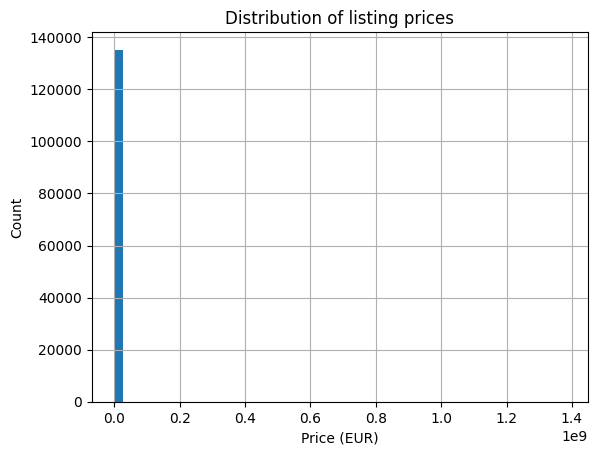

<Figure size 1000x500 with 0 Axes>

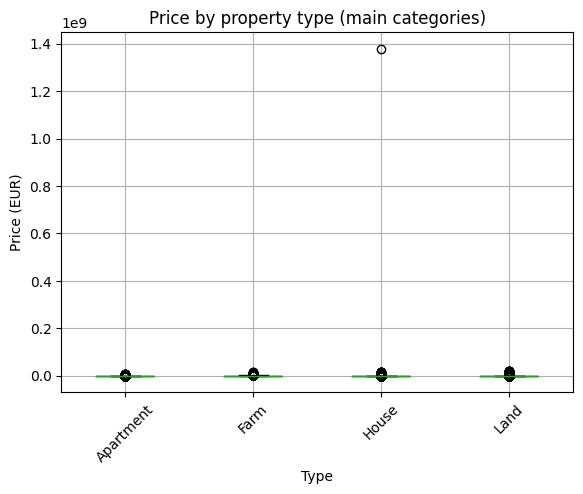

<Figure size 640x480 with 0 Axes>

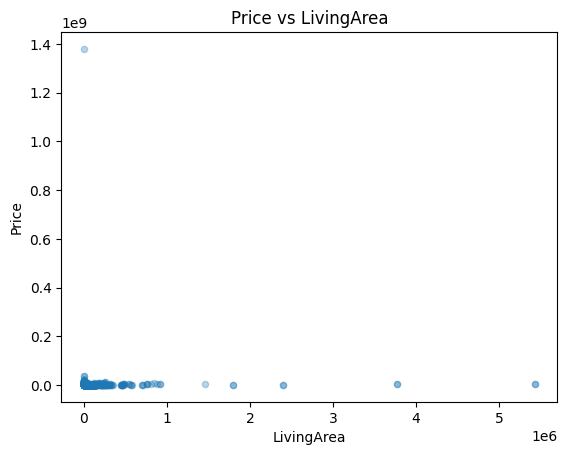

In [65]:
visualization_code_writer = student_a

start_time_vis = now()

# Price distribution
plt.figure()
data['Price'].hist(bins=50)
plt.xlabel("Price (EUR)")
plt.ylabel("Count")
plt.title("Distribution of listing prices")
plt.show()

# Price vs property type (only for main types)
plt.figure(figsize=(10, 5))
main_types = data['Type'].isin(['Apartment', 'House', 'Land', 'Farm'])
data[main_types].boxplot(column='Price', by='Type', rot=45)
plt.ylabel("Price (EUR)")
plt.title("Price by property type (main categories)")
plt.suptitle("")
plt.show()

# Price vs LivingArea
plt.figure()
data.plot.scatter(x='LivingArea', y='Price', alpha=0.3)
plt.title("Price vs LivingArea")
plt.show()

end_time_vis = now()

vis_ass_uuid_writer = "58ecb84f-cefa-4f5d-8f47-47bd1deab930" # Generated

vis_comment= """
Unfortunately we couldn't really understand what we intended in this phase as 
there are many outliers skewing all of our visualizations. Therefore we worked more on the visualizations after the preprocessing or data preparation phase.
"""

visualize_activity = [
    ':visualize_data rdf:type prov:Activity .',
    ':visualize_data rdfs:comment \'Data Understanding\' .',
    f':visualize_data rdfs:comment """{vis_comment}""" .',
    f':visualize_data prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visualize_data prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',
    f':visualize_data prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{visualization_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':visualize_data prov:used :data .',
]
engine.insert(visualize_activity, prefixes=prefixes)

In [66]:
du_manual_ass_uuid = "28116ac0-ef3d-4633-9f98-0b99b2a53423"  # Generated
du_manual_code_writer = student_a

sensitive_attrs_comment = """

The dataset doesn't include obvious sensitive personal information like gender or ethnicity.
However, the location fields (District, City, Town) can still be sensitive indirectly, because
they often reflect socio-economic differences between areas.
The data is also not evenly distributed. Most listings come from big districts like Lisboa and
Porto, while smaller districts and islands appear much less often. The property type column is 
similar: most rows are Apartments, Houses, or Land, and categories like Mansion, Hotel, or Industrial are rare.
Because of these imbalances our model might perform well overall but still work poorly for rare
districts or rare property types. So it's important to check results not just in total, but also
separately for different locations and property types.
"""

data_risks_comment = """
Potential risks and additional bias in the data include the fact that this dataset
is curated of listings published online, not all properties in Portugal therefore 
overrepresenting digitally active sellers/buyers. Another risk might be that more than 80%
of the listings with publication date were published in the year 2024, so our model won't 
be able to account for seasonality that well. One of our biggest issues is how we are going to 
account for the missing values as our dataset has a lot of them all over the different
fields. We also need to thread carefully with fields e.g. parking where encoding bias can
happen due to the fact that the 0 value could both mean "none" or "unknown".

To understand these questions better we would ask a domain expert about the time period covered, whether prices are
asking or transaction prices, how typical is for consumers to use this portal what else do they use and how
fields such as areas, energy certificate and conservation status are usually filled in. Also it would be great to have a general
concept of portugal's real-estate industry, which cities, areas are popular and is there any additional
information we should account for when molding that into our model.
"""

prep_actions_comment = """
Based on this analysis we expect to perform the following tasks. First since we have a lot
of empty values, we plan on creating a subset by eliminating a few invaluable fields or fields
with many missing values. After creating a large enough subset we will first deal with transforming
our datetype fields. Next we need to encode all of our fields with text so they can be meaningfully 
used in the modelling part of the exercise. We also have outliers in certain fields where manual 
editing is required e.g. a listing in lisbon has -13 bathrooms which is probably an typo. 
"""

du_manual_activity = [
    ':data_understanding_notes rdf:type prov:Activity .',
    ':data_understanding_notes sc:isPartOf :data_understanding_phase .',
    ':data_understanding_notes rdfs:comment "Manual reflections for 2e-2g." .',
    f':data_understanding_notes rdfs:comment """{sensitive_attrs_comment}""" .',
    f':data_understanding_notes rdfs:comment """{data_risks_comment}""" .',
    f':data_understanding_notes rdfs:comment """{prep_actions_comment}""" .',
    f':data_understanding_notes prov:qualifiedAssociation :{du_manual_ass_uuid} .',
    f':{du_manual_ass_uuid} rdf:type prov:Association .',
    f':{du_manual_ass_uuid} prov:agent :{du_manual_code_writer} .',
    f':{du_manual_ass_uuid} prov:hadRole :{code_writer_role} .',
]
engine.insert(du_manual_activity, prefixes=prefixes)


## Data Preparation

In [67]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

### Step 1 Deleting columns aligned with missing value elimination plan

In [68]:
dp_step1_code_writer = student_b

start_time_step1 = now()

clean_data1 = data.copy()
cols_to_drop = ["HasParking","ConservationStatus","BuiltArea","GrossArea","Floor","LotSize"]
clean_data1 = clean_data1.drop(columns=cols_to_drop)

end_time_step1 = now()

print("Columns dropped due to too many missing values:", cols_to_drop)
print("Columns before:", data.shape[1], "Columns after:", clean_data1.shape[1])

# Documenting the work via provo
dp_step1_ass_uuid = "39000f34-f036-49b1-8114-0455b0d50722"  # GENERATED

step1_comment = """
In Data Preparation Step 1 we removed several columns that had a very high proportion
of missing values or were considered less useful for our modelling goals. Specifically,
we eliminated HasParking, ConservationStatus, BuiltArea, GrossArea, Floor and LotSize.
This reduces noise and complexity in the dataset while keeping the key information
about price, location, property type, areas and rooms. The number of rows stayed the
same, but the number of features decreased from 25 to 19.
""" 

step1_triples = [
    ':elim_many_missing_cols rdf:type prov:Activity .',
    ':elim_many_missing_cols sc:isPartOf :data_preparation_phase .',
    ':elim_many_missing_cols rdfs:comment "Data Preparation Step 1" .',
    f':elim_many_missing_cols rdfs:comment """{step1_comment}""" .',
    f':elim_many_missing_cols prov:startedAtTime "{start_time_step1}"^^xsd:dateTime .',
    f':elim_many_missing_cols prov:endedAtTime "{end_time_step1}"^^xsd:dateTime .',
    ':elim_many_missing_cols prov:used :data .',
    f':elim_many_missing_cols prov:qualifiedAssociation :{dp_step1_ass_uuid} .',
    f':{dp_step1_ass_uuid} rdf:type prov:Association .',
    f':{dp_step1_ass_uuid} prov:agent :{dp_step1_code_writer} .',
    f':{dp_step1_ass_uuid} prov:hadRole :{code_writer_role} .',

    ':data_column_removal rdf:type prov:Entity .',
    ':data_column_removal prov:wasGeneratedBy :elim_many_missing_cols .',
    ':data_column_removal sc:name "Listings without columns that have too many missing values" .',
    ':data_column_removal prov:wasDerivedFrom :data .',
    f':data_column_removal mls:hasNumberOfInstances "{len(clean_data1)}"^^xsd:integer .',
    f':data_column_removal mls:hasNumberOfFeatures "{clean_data1.shape[1]}"^^xsd:integer .',

    ':elim_many_missing_cols prov:generated :data_column_removal .',
]

engine.insert(step1_triples, prefixes=prefixes)

Columns dropped due to too many missing values: ['HasParking', 'ConservationStatus', 'BuiltArea', 'GrossArea', 'Floor', 'LotSize']
Columns before: 25 Columns after: 19


### Step 2 Deleting rows with missing values left after column removal

In [69]:
dp_step2_code_writer = student_b

start_time_step2 = now()

rows_before = len(clean_data1)
clean_data2 = clean_data1.dropna().reset_index(drop=True)
rows_after = len(clean_data2)

end_time_step2 = now()

print("Rows before dropping missing:", rows_before)
print("Rows after dropping missing:", rows_after)

# Documenting step 2 of data preparation
dp_step2_ass_uuid = "4cb2e89a-5994-4839-b3cc-b0c5c048d12c" # Generated

removed = rows_before - rows_after
removed_pct = removed / rows_before if rows_before > 0 else 0.0

print("Dropped rows:", removed)
print("Dropped rows percentage:", removed_pct)

step2_comment = """
In Data Preparation Step 2 we removed all rows that still contained at least one missing
value after eliminating the highly incomplete columns in Step 1. This gives us a cleaner,
fully complete dataset for modelling at the cost of discarding some listings that had
missing information in important fields. This step left us with 6723 rows with no missing values and 19 columns.
"""

step2_triples = [
    ':elim_rows_with_missing rdf:type prov:Activity .',
    ':elim_rows_with_missing sc:isPartOf :data_preparation_phase .',
    ':elim_rows_with_missing rdfs:comment "Data Preparation step 2" .',
    f':elim_rows_with_missing rdfs:comment """{step2_comment}""" .',
    f':elim_rows_with_missing prov:startedAtTime "{start_time_step2}"^^xsd:dateTime .',
    f':elim_rows_with_missing prov:endedAtTime "{end_time_step2}"^^xsd:dateTime .',
    ':elim_rows_with_missing prov:used :data_column_removal .',
    f':elim_rows_with_missing prov:qualifiedAssociation :{dp_step2_ass_uuid} .',
    f':{dp_step2_ass_uuid} rdf:type prov:Association .',
    f':{dp_step2_ass_uuid} prov:agent :{dp_step2_code_writer} .',
    f':{dp_step2_ass_uuid} prov:hadRole :{code_writer_role} .',

    ':data_no_missing_rows rdf:type prov:Entity .',
    ':data_no_missing_rows prov:wasGeneratedBy :elim_rows_with_missing .',
    ':data_no_missing_rows sc:name "Listings without any missing values" .',
    ':data_no_missing_rows prov:wasDerivedFrom :data_column_removal .',
    f':data_no_missing_rows mls:hasNumberOfInstances "{rows_after}"^^xsd:integer .',
    f':data_no_missing_rows mls:hasNumberOfFeatures "{clean_data2.shape[1]}"^^xsd:integer .',

    ':elim_rows_with_missing prov:generated :data_no_missing_rows .',
]

engine.insert(step2_triples, prefixes=prefixes)

Rows before dropping missing: 135536
Rows after dropping missing: 6723
Dropped rows: 128813
Dropped rows percentage: 0.9503969425097392


### Step 3 Outlier removal

In [70]:
dp_step3_code_writer = student_b

numeric_cols_for_outliers = [
    "Price",
    "TotalArea",
    "LivingArea",
    "LotSize",
    "ConstructionYear",
    "TotalRooms",
    "NumberOfBedrooms",
    "NumberOfWC",
    "NumberOfBathrooms",
]

start_time_step3 = now()

# Use your earlier IQR-based function
outlier_report = check_outliers(clean_data2, columns=numeric_cols_for_outliers, iqr_multiplier=3)

# collect all row indices flagged as outliers for any column
indices_to_drop = sorted(
    {item["index"] for col_items in outlier_report.values() for item in col_items}
)

rows_before = len(clean_data2)
clean_data3 = clean_data2.drop(index=indices_to_drop).reset_index(drop=True)
rows_after = len(clean_data3)

end_time_step3 = now()

print("Outlier rows to drop:", len(indices_to_drop))
print("Rows before:", rows_before, "Rows after:", rows_after)

# Documentation for step 3
dp_step3_ass_uuid = "5e7a1d08-2195-44be-9148-944441bedf2f" # Generated

# small summary for ourselves
per_col_counts = {col: len(items) for col, items in outlier_report.items()}
summary_parts = [f"{col}: {cnt} rows" for col, cnt in per_col_counts.items()]
outlier_summary_str = "; ".join(summary_parts)

step3_comment = (
    "Data Preparation step 3: removed rows flagged as outliers by an IQR-based rule "
    "for selected numeric columns (multiplier 3). "
    f"Total outlier rows removed: {len(indices_to_drop)}. "
    f"Rows before: {rows_before}, rows after: {rows_after}. "
    f"Outliers per column: {outlier_summary_str}."
)

step3_triples = [
    ':remove_outliers rdf:type prov:Activity .',
    ':remove_outliers sc:isPartOf :data_preparation_phase .',
    ':remove_outliers rdfs:comment "Data Preparation step 3" .',
    f':remove_outliers rdfs:comment "{step3_comment}" .',
    f':remove_outliers prov:startedAtTime "{start_time_step3}"^^xsd:dateTime .',
    f':remove_outliers prov:endedAtTime "{end_time_step3}"^^xsd:dateTime .',
    ':remove_outliers prov:used :data_no_missing_rows .',
    f':remove_outliers prov:qualifiedAssociation :{dp_step3_ass_uuid} .',
    f':{dp_step3_ass_uuid} rdf:type prov:Association .',
    f':{dp_step3_ass_uuid} prov:agent :{dp_step3_code_writer} .',
    f':{dp_step3_ass_uuid} prov:hadRole :{code_writer_role} .',

    ':data_no_outliers rdf:type prov:Entity .',
    ':data_no_outliers prov:wasGeneratedBy :remove_outliers .',
    ':data_no_outliers sc:name "Listings without extreme outliers" .',
    ':data_no_outliers prov:wasDerivedFrom :data_no_missing_rows .',
    f':data_no_outliers mls:hasNumberOfInstances "{rows_after}"^^xsd:integer .',
    f':data_no_outliers mls:hasNumberOfFeatures "{clean_data3.shape[1]}"^^xsd:integer .',

    ':remove_outliers prov:generated :data_no_outliers .',
]

engine.insert(step3_triples, prefixes=prefixes)

Outlier rows to drop: 586
Rows before: 6723 Rows after: 6137


### Self check of outlier removal success

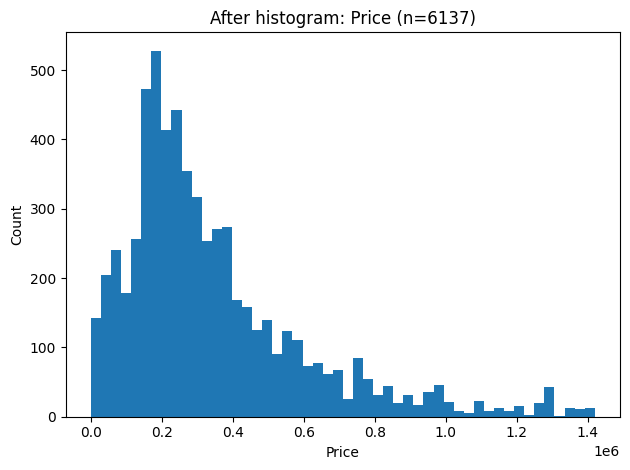

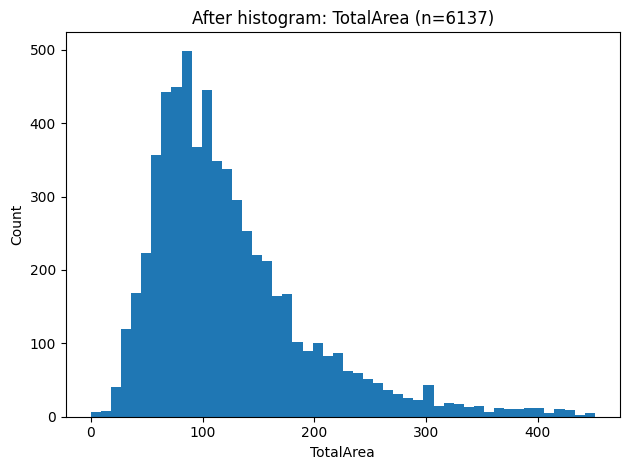

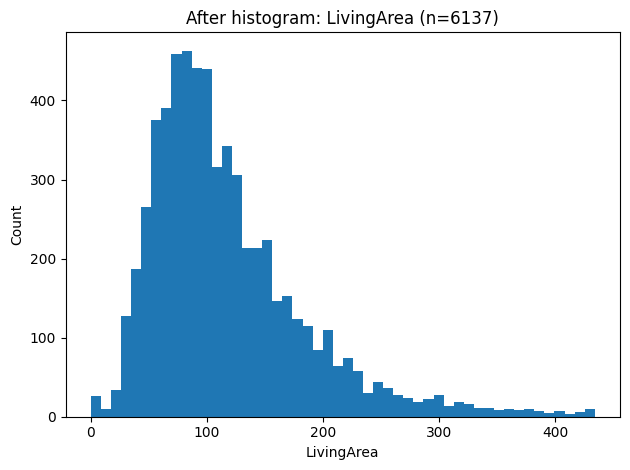

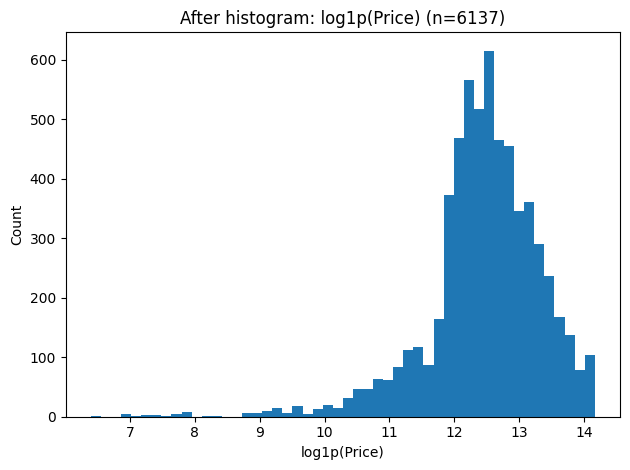

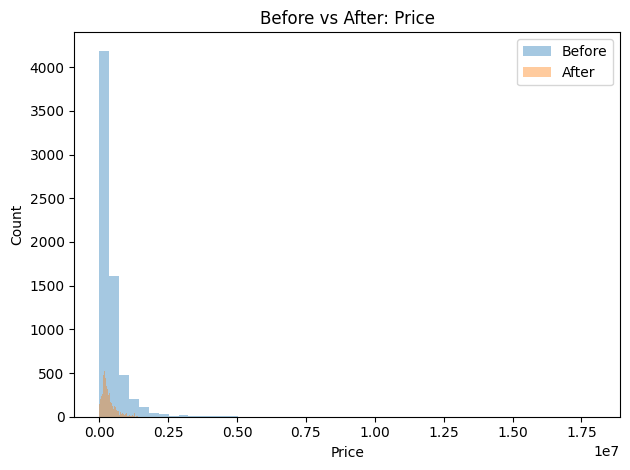

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df_after = clean_data3

df_before = clean_data2  

numeric_cols = [
    "Price",
    "TotalArea",
    "LivingArea",
]

def plot_histograms(df, cols, title_prefix="After"):
    for col in cols:
        if col not in df.columns:
            continue
        x = pd.to_numeric(df[col], errors="coerce").dropna()
        if x.empty:
            continue

        plt.figure()
        plt.hist(x, bins=50)
        plt.title(f"{title_prefix} histogram: {col} (n={len(x)})")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

def plot_log_price(df, title_prefix="After"):
    if "Price" not in df.columns:
        return
    x = pd.to_numeric(df["Price"], errors="coerce").dropna()
    if x.empty:
        return
    x_log = np.log1p(x)

    plt.figure()
    plt.hist(x_log, bins=50)
    plt.title(f"{title_prefix} histogram: log1p(Price) (n={len(x_log)})")
    plt.xlabel("log1p(Price)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# --- AFTER outlier removal ---
plot_histograms(df_after, numeric_cols, title_prefix="After")
plot_log_price(df_after, title_prefix="After")

# BEFORE vs AFTER comparison
if df_before is not None:
    for col in ["Price"]:
        if col not in df_before.columns or col not in df_after.columns:
            continue
        b = pd.to_numeric(df_before[col], errors="coerce").dropna()
        a = pd.to_numeric(df_after[col], errors="coerce").dropna()
        if b.empty or a.empty:
            continue

        plt.figure()
        plt.hist(b, bins=50, alpha=0.4, label="Before")
        plt.hist(a, bins=50, alpha=0.4, label="After")
        plt.title(f"Before vs After: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()


### Step - 3.1 Standard Scaler

In [72]:
from sklearn.preprocessing import StandardScaler

dp_step31_code_writer = student_b

start_time_step31 = now()

# start from data after outlier removal
clean_data31 = clean_data3.copy()

# select numeric columns
numeric_cols = clean_data31.select_dtypes(include=["int64", "float64"]).columns.tolist()

# remove Price from scaling (we log-transform it later)
numeric_cols = [c for c in numeric_cols if c != "Price"]

scaler = StandardScaler()
clean_data31[numeric_cols] = scaler.fit_transform(clean_data31[numeric_cols])

end_time_step31 = now()

print("Scaled numeric columns (excluding Price):")
print(numeric_cols)


dp_step31_ass_uuid = "95083b24-4ccf-4a25-9f92-64b4295ee864"  #GENERATED

step31_comment = """
In Data Preparation Step 3.1 we standardised all numeric input features except the
target variable Price. For each numeric column we subtracted its mean and divided
by its standard deviation (StandardScaler), so that these features have approximately
zero mean and unit variance. Price itself is not scaled here, because we treat it
separately with a log transformation in the next step.
"""

step31_triples = [
    

    # Activity: scaling numeric features
    ':scale_numeric_features rdf:type prov:Activity .',
    ':scale_numeric_features sc:isPartOf :data_preparation_phase .',
    ':scale_numeric_features rdfs:comment "Data Preparation step 3.1" .',
    f':scale_numeric_features rdfs:comment """{step31_comment}""" .',
    f':scale_numeric_features prov:startedAtTime "{start_time_step31}"^^xsd:dateTime .',
    f':scale_numeric_features prov:endedAtTime "{end_time_step31}"^^xsd:dateTime .',
    ':scale_numeric_features prov:used :data_no_outliers .',          # input dataset
    f':scale_numeric_features prov:qualifiedAssociation :{dp_step31_ass_uuid} .',
    f':{dp_step31_ass_uuid} rdf:type prov:Association .',
    f':{dp_step31_ass_uuid} prov:agent :{dp_step31_code_writer} .',
    f':{dp_step31_ass_uuid} prov:hadRole :{code_writer_role} .',

    # New entity: dataset after scaling numeric features
    ':data_scaled_features rdf:type prov:Entity .',
    ':data_scaled_features sc:name "Listings with scaled numeric features (excluding Price)" .',
    ':data_scaled_features sc:description "Dataset after outlier removal and standardisation of numeric features other than Price." .',
    ':data_scaled_features prov:wasGeneratedBy :scale_numeric_features .',
    ':data_scaled_features prov:wasDerivedFrom :data_no_outliers .',  # adapt if your previous entity has a different name
    f':data_scaled_features mls:hasNumberOfInstances "{len(clean_data31)}"^^xsd:integer .',
    f':data_scaled_features mls:hasNumberOfFeatures "{clean_data31.shape[1]}"^^xsd:integer .',

    ':scale_numeric_features prov:generated :data_scaled_features .',
]

engine.insert(step31_triples, prefixes=prefixes)

Scaled numeric columns (excluding Price):
['TotalArea', 'Parking', 'ConstructionYear', 'TotalRooms', 'NumberOfBedrooms', 'NumberOfWC', 'LivingArea', 'NumberOfBathrooms']


### Step 4 Log-scaling the Price column

In [73]:
dp_step4_code_writer = student_b

start_time_step4 = now()

clean_data4 = clean_data31.copy()

# log-transform price to reduce right skew
clean_data4["Price_log"] = np.log1p(clean_data4["Price"])

#standardize the log price for modelling
price_log_mean = clean_data4["Price_log"].mean()
price_log_std = clean_data4["Price_log"].std()
clean_data4["Price_log_scaled"] = (clean_data4["Price_log"] - price_log_mean) / price_log_std

end_time_step4 = now()

cleaned_data = clean_data4
print(cleaned_data.head())


# Documentation for step 4
dp_step4_ass_uuid = "271b1b03-3623-4dd3-a29c-cbe56c5bb339" # Generated

step4_comment = """
In Data Preparation Step 4 we transformed the strongly right-skewed Price distribution
using a natural logarithm (log1p). This reduces the influence of very expensive
properties and makes the distribution more symmetric, even though it is now slightly
left-skewed. We then standardized the log-transformed price to create a new variable
Price_log_scaled by subtracting its mean and dividing by its standard deviation.
The original Price in EUR is kept for interpretation, while Price_log and
Price_log_scaled can be used for modelling.
"""

step4_triples = [
    ':log_transform rdf:type prov:Activity .',
    ':log_transform sc:isPartOf :data_preparation_phase .',
    ':log_transform rdfs:comment "Data Preparation step 4" .',
    f':log_transform rdfs:comment """{step4_comment}""" .',
    f':log_transform prov:startedAtTime "{start_time_step4}"^^xsd:dateTime .',
    f':log_transform prov:endedAtTime "{end_time_step4}"^^xsd:dateTime .',
    ':log_transform prov:used :data_scaled_features .',
    f':log_transform prov:qualifiedAssociation :{dp_step4_ass_uuid} .',
    f':{dp_step4_ass_uuid} rdf:type prov:Association .',
    f':{dp_step4_ass_uuid} prov:agent :{dp_step4_code_writer} .',
    f':{dp_step4_ass_uuid} prov:hadRole :{code_writer_role} .',

    # our log scaled dataset is documented here
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasGeneratedBy :log_transform .',
    ':prepared_data sc:name "Listings Price column log transformed, final clean dataset prepared" .',
    ':prepared_data prov:wasDerivedFrom :data_scaled_features .',
    f':prepared_data mls:hasNumberOfInstances "{rows_after}"^^xsd:integer .',
    f':prepared_data mls:hasNumberOfFeatures "{cleaned_data.shape[1]}"^^xsd:integer .',

    ':log_transform prov:generated :prepared_data .',
]

engine.insert(step4_triples, prefixes=prefixes)

      Price District                City  \
0   98000.0   Aveiro  Albergaria-a-Velha   
1  390000.0   Aveiro              Ílhavo   
2  250000.0   Aveiro              Aveiro   
3  425000.0   Aveiro                Ovar   
4  236000.0   Aveiro  Oliveira do Bairro   

                                                  Town       Type  \
0                        Albergaria-a-Velha e Valmaior  Apartment   
1                                         São Salvador      House   
2                                   Glória e Vera Cruz  Apartment   
3  Ovar, São João, Arada e São Vicente de Pereira Jusã      House   
4                                                  Oiã  Apartment   

  EnergyCertificate  TotalArea   Parking  ConstructionYear  \
0                 F  -0.617073 -0.741450          0.044059   
1                 D  -0.264771 -0.741450         -0.451164   
2                 B  -0.955282  1.348709          1.224975   
3                 D   0.566661  1.348709          0.044059   
4         

### 4.1 Date tranformation and Year binning

In [74]:
dp_step41_code_writer = student_b

start_time_step41 = now()

data_with_year_bins = cleaned_data.copy()

# Make sure ConstructionYear is numeric
data_with_year_bins["ConstructionYear"] = pd.to_numeric(
    data_with_year_bins["ConstructionYear"], errors="coerce"
)

# Define bins and labels (adjust if you like)
bins = [1900, 1970, 1990, 2010, 2030]
labels = ["<=1970", "1971-1990", "1991-2010", ">2010"]

data_with_year_bins["ConstructionYearBin"] = pd.cut(
    data_with_year_bins["ConstructionYear"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True,
)

end_time_step41 = now()

data_with_year_bins["ConstructionYearBin"].value_counts(dropna=False)

dp_step41_ass_uuid = "4da49cf0-fa7b-453b-9e5f-9648a34c5771"  # GENERATED

step41_comment = """
In Data Preparation Step 4.1 we derived a categorical feature that groups the
construction year of each property into broad time periods. Starting from the
numeric ConstructionYear column, we defined bins (<=1970, 1971–1990, 1991–2010,
>2010) and created a new variable 'ConstructionYearBin' using pd.cut. This allows
the model to capture differences between older and newer buildings in a simple,
interpretable way, and we treat this binned feature as an additional categorical
input in the encoding step.
"""

step41_triples = [
    # Activity: adding year bins
    ':add_year_bins rdf:type prov:Activity .',
    ':add_year_bins sc:isPartOf :data_preparation_phase .',
    ':add_year_bins rdfs:comment "Data Preparation step 4.1" .',
    f':add_year_bins rdfs:comment """{step41_comment}""" .',
    f':add_year_bins prov:startedAtTime "{start_time_step41}"^^xsd:dateTime .',
    f':add_year_bins prov:endedAtTime "{end_time_step41}"^^xsd:dateTime .',
    ':add_year_bins prov:used :prepared_data .',           # input dataset
    f':add_year_bins prov:qualifiedAssociation :{dp_step41_ass_uuid} .',
    f':{dp_step41_ass_uuid} rdf:type prov:Association .',
    f':{dp_step41_ass_uuid} prov:agent :{dp_step41_code_writer} .',
    f':{dp_step41_ass_uuid} prov:hadRole :{code_writer_role} .',

# New entity: dataset with binned construction year
    ':data_with_year_bins rdf:type prov:Entity .',
    ':data_with_year_bins sc:name "Listings with binned construction year" .',
    ':data_with_year_bins sc:description "Prepared dataset with an additional categorical feature ConstructionYearBin representing building age groups." .',
    ':data_with_year_bins prov:wasGeneratedBy :add_year_bins .',
    ':data_with_year_bins prov:wasDerivedFrom :prepared_data .',  # prepared_data after log-scaling Price
    f':data_with_year_bins mls:hasNumberOfInstances "{len(data_with_year_bins)}"^^xsd:integer .',
    f':data_with_year_bins mls:hasNumberOfFeatures "{data_with_year_bins.shape[1]}"^^xsd:integer .',
    
    ':add_year_bins prov:generated :data_with_year_bins .',
]

engine.insert(step41_triples, prefixes=prefixes)

## Step 5 Encoding

In [75]:
dp_step5_code_writer = student_b  # Person B

start_time_step5 = now()

# Choose categorical columns to encode
categorical_cols = [
    "District",
    "City",
    "Town",
    "Type",
    "EnergyCertificate",
    "EnergyEfficiencyLevel",
    "ConstructionYearBin",
]
prepared_data = data_with_year_bins.copy()
# Make sure all of them exist (in case you dropped some earlier)
categorical_cols = [c for c in categorical_cols if c in prepared_data.columns]

rows_before = len(prepared_data)
cols_before = prepared_data.shape[1]

# One-hot encode, drop_first=True to avoid full dummy trap
encoded_data = pd.get_dummies(
    prepared_data,
    columns=categorical_cols,
    drop_first=True,
)

rows_after = len(encoded_data)
cols_after = encoded_data.shape[1]

end_time_step5 = now()

print("Encoding step:")
print("  Rows before/after:", rows_before, "/", rows_after)
print("  Columns before/after:", cols_before, "/", cols_after)


prepared_data_encoded = encoded_data # FINAL DATASET NAME
if "PublishDate" in prepared_data_encoded.columns: # drop PublishDate if still present, we don't need it
    prepared_data_encoded = prepared_data_encoded.drop(columns=["PublishDate"])
bool_cols = ["Garage", "Elevator", "ElectricCarsCharging"]

true_tokens = {"1", "True", "yes", "y", "sim"}  # we realized later that these were object types

for col in bool_cols:
    if col in prepared_data_encoded.columns:
        prepared_data_encoded[col] = (
            prepared_data_encoded[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .isin(true_tokens)
        )

dp_step5_ass_uuid = "94f32604-1795-4e32-917d-da3fea2aa938"  # Generated

step5_comment = """
In Data Preparation Step 5 we encoded the main categorical attributes using one-hot
encoding so that they can be used in standard ML models. Specifically, we created
binary indicator variables for District, City, Town, Type, EnergyCertificate and
EnergyEfficiencyLevel. The number of rows stayed the same, but the number of
features increased due to the new dummy columns. The resulting dataset
'prepared_data_encoded' is used as input for modelling.
"""

step5_triples = [
   
    # Activity: encoding categoricals
    ':encode_categoricals rdf:type prov:Activity .',
    ':encode_categoricals sc:isPartOf :data_preparation_phase .',
    ':encode_categoricals rdfs:comment "Data Preparation step 5" .',
    f':encode_categoricals rdfs:comment """{step5_comment}""" .',
    f':encode_categoricals prov:startedAtTime "{start_time_step5}"^^xsd:dateTime .',
    f':encode_categoricals prov:endedAtTime "{end_time_step5}"^^xsd:dateTime .',
    ':encode_categoricals prov:used :data_with_year_bins .',
    f':encode_categoricals prov:qualifiedAssociation :{dp_step5_ass_uuid} .',
    f':{dp_step5_ass_uuid} rdf:type prov:Association .',
    f':{dp_step5_ass_uuid} prov:agent :{dp_step5_code_writer} .',
    f':{dp_step5_ass_uuid} prov:hadRole :{code_writer_role} .',

     # New entity: encoded dataset
    ':prepared_data_encoded rdf:type prov:Entity .',
    ':prepared_data_encoded sc:name "Final preprocessed and encoded listings dataset" .',
    ':prepared_data_encoded prov:wasGeneratedBy :encode_categoricals .',
    ':prepared_data_encoded prov:wasDerivedFrom :data_with_year_bins .',
    f':prepared_data_encoded mls:hasNumberOfInstances "{rows_after}"^^xsd:integer .',
    f':prepared_data_encoded mls:hasNumberOfFeatures "{cols_after}"^^xsd:integer .',

    ':encode_categoricals prov:generated :prepared_data_encoded .',

]

engine.insert(step5_triples, prefixes=prefixes)

Encoding step:
  Rows before/after: 6137 / 6137
  Columns before/after: 22 / 1298


**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [76]:
dp_3bcd_code_writer = student_b
dp_3bcd_ass_uuid = "d187b4d9-0123-4ebd-a1bf-dc3e0c59de7e"  # generated

dp_not_applied_comment = """
We considered using more advanced missing-value strategies (e.g. median or k-NN
imputation) instead of removing all rows with missing values. We decided against
this to keep the pipeline simple and did not want to add any artifital bias by imputation. Also, the remaining
sample size after row deletion was still large enough for our experiments.
We also considered transforming features further, for example by grouping numeric values 
into bins or recoding categories into fewer groups. We decided not to do this at this stage, 
because it would throw away information and make the features harder to interpret. Instead, we 
kept the original continuous variables and only applied a log transformation to Price. 
Finally, we did not yet apply one-hot encoding or more complex encoding schemes for categorical 
variables in this phase, because we plan to handle this later in the modelling pipeline.
"""

dp_derived_attrs_comment = """
We identified several meaningful derived attributes that could be created in a
later step, such as: price per square meter (Price divided by LivingArea or
TotalArea), age of the property at listing time (PublishDate year minus
ConstructionYear) and simple boolean features like 'is_new_build' for recent construction
years or 'is_large_property' based on area thresholds. These features could help
capture non-linear relationships in a more direct way. For the current version of
the project we keep the preprocessing focused on cleaning, outlier removal and
Price transformation and treat additional feature engineering as optional/planned future
work if model performance is not satisfactory.
"""

dp_external_data_comment = """
To improve the model, we could enrich the listings with external data such as:
demographic socio-economic indicators (average income, unemployment rates),
liveability of the neighborhood (city centre, public transport, schools, hospitals,
parks). Combining such data with the current dataset would likely increase predictive 
power and help explain regional price differences. 
"""

dp_3bcd_triples = [
    ':data_preparation_notes rdf:type prov:Activity .',
    ':data_preparation_notes sc:isPartOf :data_preparation_phase .',
    ':data_preparation_notes rdfs:comment "Manual notes for Data Preparation tasks 3b-3d." .',
    f':data_preparation_notes rdfs:comment """{dp_not_applied_comment}""" .',
    f':data_preparation_notes rdfs:comment """{dp_derived_attrs_comment}""" .',
    f':data_preparation_notes rdfs:comment """{dp_external_data_comment}""" .',
    f':data_preparation_notes prov:qualifiedAssociation :{dp_3bcd_ass_uuid} .',
    f':{dp_3bcd_ass_uuid} rdf:type prov:Association .',
    f':{dp_3bcd_ass_uuid} prov:agent :{dp_3bcd_code_writer} .',
    f':{dp_3bcd_ass_uuid} prov:hadRole :{code_writer_role} .',
]

engine.insert(dp_3bcd_triples, prefixes=prefixes)

## Modeling

In [77]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [78]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "8d2a2324-172d-4387-b4c9-289355583e06" # Generated
dma_comment = """
For this regression problem we considered several algorithm families: linear models
(Ridge/Lasso), tree-based ensembles (Random Forest) and gradient boosting methods
such as XGBoost. Simple linear models are easy to interpret but are limited in how
well they can capture non-linear relationships in our data. RandomForestRegressor is
a strong baseline for tabular data, but with our large number of one-hot encoded
features (more than a thousand columns) it becomes relatively slow and memory
intensive.

We therefore choose XGBRegressor (XGBoost) as our main model. XGBoost is designed to
handle high-dimensional, sparse feature spaces efficiently, offers good predictive
performance on tabular data and provides useful regularisation and subsampling
options to control overfitting. In our preliminary experiments it was also faster
than a comparable RandomForestRegressor on this dataset. 
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':xgboost_algorithm rdf:type mls:Algorithm .',
    f':xgboost_algorithm rdfs:label "XGBoost Regressor" .',

    # example implementation
    f':xgboost_implementation rdf:type mls:Implementation .',
    f':xgboost_implementation rdfs:label "xgboost XGBRegressor" .',
    f':xgboost_implementation mls:implements :xgboost_algorithm .',
    f':xgboost_implementation prov:wasGeneratedBy :define_algorithm .',

    #Evaluation MEtrics
    
    # MAE
    ':mae_measure rdf:type mls:EvaluationMeasure .',
    ':mae_measure rdfs:label "Mean Absolute Error (MAE)" .',
    ':mae_measure rdfs:comment "MAE is our primary regression metric. It reports the average absolute difference between predicted and true log-price values. Lower MAE indicates better performance and it is relatively robust to outliers." .',
    ':mae_measure prov:wasGeneratedBy :define_algorithm .',

    # RMSE
    ':rmse_measure rdf:type mls:EvaluationMeasure .',
    ':rmse_measure rdfs:label "Root Mean Squared Error (RMSE)" .',
    ':rmse_measure rdfs:comment "RMSE is the square root of the average squared error between predicted and true log-price values. It penalises larger errors more strongly than MAE and is useful to detect models that occasionally make very large mistakes." .',
    ':rmse_measure prov:wasGeneratedBy :define_algorithm .',

    # R2
    ':r2_score_measure rdf:type mls:EvaluationMeasure .',
    ':r2_score_measure rdfs:label "R-squared (R2) Score" .',
    ':r2_score_measure rdfs:comment "R2 measures how much of the variance in the log-transformed price is explained by the model compared to predicting the mean. We interpret it together with MAE and RMSE." .',
    ':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [79]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "2b708200-36a1-4ac0-9808-850820a97b3e" # Generated
hp_comment = """
For XGBRegressor we documented the main hyper-parameters that influence model complexity
and computation: n_estimators, learning_rate, max_depth, subsample, colsample_bytree and
reg_lambda. To keep the tuning process focused and interpretable, we decided to tune
max_depth as the primary hyper-parameter, because it directly controls how complex the
individual trees can become and therefore how strongly the model can overfit. The other
hyper-parameters are fixed to explicit values for reproducibility
(n_estimators=300, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
random_state=42, tree_method="hist").
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # n_estimators (fixed)
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "Number of Trees (n_estimators)" .',
    f':hp_n_estimators rdfs:comment "Number of boosting trees used in the XGBoost model. We fix n_estimators = 300 to provide a reasonably strong model without excessive training time." .',
    f':hp_n_estimators rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_n_estimators .',
    f':hp_n_estimators prov:wasGeneratedBy :identify_hyperparameters .',

    # learning_rate (fixed)
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "Step size shrinkage used in each boosting step. We fix learning_rate = 0.05 so that each tree makes a relatively small update, which stabilises training and typically improves generalisation." .',
    f':hp_learning_rate rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # subsample (fixed)
    f':hp_subsample rdf:type mls:HyperParameter .',
    f':hp_subsample rdfs:label "Subsample" .',
    f':hp_subsample rdfs:comment "Fraction of training instances sampled for each tree. We fix subsample = 0.8 to add randomness and reduce overfitting while still using most of the data per tree." .',
    f':hp_subsample rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_subsample .',
    f':hp_subsample prov:wasGeneratedBy :identify_hyperparameters .',

    # colsample_bytree (fixed)
    f':hp_colsample_bytree rdf:type mls:HyperParameter .',
    f':hp_colsample_bytree rdfs:label "Column Subsample (colsample_bytree)" .',
    f':hp_colsample_bytree rdfs:comment "Fraction of features sampled for each tree. With many one-hot encoded columns we fix colsample_bytree = 0.8 so each tree sees only a subset of features, which improves efficiency and regularisation." .',
    f':hp_colsample_bytree rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_colsample_bytree .',
    f':hp_colsample_bytree prov:wasGeneratedBy :identify_hyperparameters .',

    # reg_lambda (fixed)
    f':hp_reg_lambda rdf:type mls:HyperParameter .',
    f':hp_reg_lambda rdfs:label "L2 Regularisation (reg_lambda)" .',
    f':hp_reg_lambda rdfs:comment "L2 regularisation term on leaf weights. We fix reg_lambda = 1.0 as a moderate amount of regularisation to penalise very large weights and reduce overfitting." .',
    f':hp_reg_lambda rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_reg_lambda .',
    f':hp_reg_lambda prov:wasGeneratedBy :identify_hyperparameters .',

    # random_state (fixed)
    f':hp_random_state rdf:type mls:HyperParameter .',
    f':hp_random_state rdfs:label "Random State" .',
    f':hp_random_state rdfs:comment "Random seed used to make the training process reproducible. We fix random_state = 42 so that our splits and model results can be reproduced consistently." .',
    f':hp_random_state rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_random_state .',
    f':hp_random_state prov:wasGeneratedBy :identify_hyperparameters .',

    # tree_method (fixed)
    f':hp_tree_method rdf:type mls:HyperParameter .',
    f':hp_tree_method rdfs:label "Tree Method" .',
    f':hp_tree_method rdfs:comment "Algorithm used to construct the trees. We fix tree_method = \\"hist\\" (histogram-based), which is efficient for larger datasets with many features." .',
    f':hp_tree_method rdfs:comment "fixed" .',
    f':xgboost_implementation mls:hasHyperParameter :hp_tree_method .',
    f':hp_tree_method prov:wasGeneratedBy :identify_hyperparameters .',

    # max_depth (primary tuned hyper-parameter)
    f':hp_max_depth rdf:type mls:HyperParameter .',
    f':hp_max_depth rdfs:label "Max Depth" .',
    f':hp_max_depth rdfs:comment "Maximum depth of the individual trees in XGBoost. This controls how complex each tree can become and has a strong influence on underfitting vs. overfitting." .',
    f':hp_max_depth rdfs:comment "primary hyper-parameter to be tuned (we evaluate several values for max_depth while keeping the other hyper-parameters fixed)." .',
    f':xgboost_implementation mls:hasHyperParameter :hp_max_depth .',
    f':hp_max_depth prov:wasGeneratedBy :identify_hyperparameters .',
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

## Model functions

In [80]:
from sklearn.model_selection import train_test_split

def split_data(df: pd.DataFrame):
    y = prepared_data_encoded["Price_log"]
    X = prepared_data_encoded.drop(
        columns=["Price", "Price_log"],
        errors="ignore",
    )

    #bins so we can do stratified splitting
    price_bins = pd.qcut(y, q=5, labels=False, duplicates="drop")

    #train+val vs test (80 / 20)
    X_train_val, X_test, y_train_val, y_test, bins_train_val, bins_test = train_test_split(
        X,
        y,
        price_bins,
        test_size=0.2,
        random_state=12432929, #random seed for reproducibility matriculation number
        stratify=price_bins,  # comment out if you get an error
    )

    #train vs validation from train+val (60 / 20 overall)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.25,  # 0.25 of 0.8 = 0.2 overall -> 60/20/20
        random_state=12432929, #random seed for reproducibility matriculation number
    ) 
    return X_train, X_val, X_test, y_train, y_val, y_test

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "30a0d525-b602-438b-9067-4719fff14517" # Generated
split_comment = """
In Modeling Step 4c we split the prepared dataset into three disjoint subsets:
training, validation and test. We first separated a test set comprising 20 percent of
the data, and then split the remaining 80 percent into a training set (60 percent of the total
data) and a validation set (20 percent of the total data), resulting in an overall
60/20/20 split. We used a fixed random_state = 42 in both splitting operations
to ensure that the split is fully reproducible.

To keep the distribution of the target variable (log-transformed price) similar
across the subsets, we stratified the first split using approximate price bins
based on quantiles of Price_log. If stratification is disabled in a different
run, the split becomes purely random but remains reproducible due to the fixed
random_state.
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains 60% samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains 20% samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains 20% samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

,max_depth,MAE,RMSE,R2
0,1,0.055396,0.079583,0.992669
1,2,0.035076,0.054470,0.996566
2,3,0.028137,0.047669,0.997370
3,4,0.027585,0.045385,0.997616
4,5,0.029128,0.048765,0.997248
5,6,0.032233,0.054066,0.996617
6,9,0.049168,0.081609,0.992291
7,12,0.061768,0.098209,0.988837


Best max_depth: 4


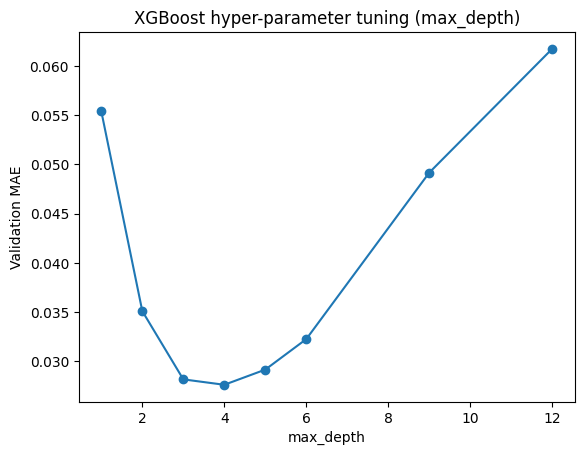

In [81]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

base_xgb_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=12432929,
    tree_method="hist",
    objective="reg:squarederror",
    n_jobs=-1,
)

def train_and_finetune_model():
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(prepared_data_encoded)

    candidate_max_depths = [1, 2, 3, 4, 5, 6, 9, 12]
    tuning_results = []

    for md in candidate_max_depths:
        model = XGBRegressor(
            **base_xgb_params,
            max_depth=md,
        )
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_val_pred)
        rmse = root_mean_squared_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)

        tuning_results.append({
            "max_depth": md,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
        })

    tuning_df2 = pd.DataFrame(tuning_results).sort_values("MAE").reset_index(drop=True)
    tuning_df = pd.DataFrame(tuning_results).reset_index(drop=True)
    display(tuning_df)

    best_row = tuning_df2.iloc[0]
    best_max_depth = int(best_row["max_depth"])
    print("Best max_depth:", best_max_depth)

    # 4e) Plot tuning curve
    plt.figure()
    plt.plot(tuning_df["max_depth"], tuning_df["MAE"], marker="o")
    plt.xlabel("max_depth")
    plt.ylabel("Validation MAE")
    plt.title("XGBoost hyper-parameter tuning (max_depth)")
    plt.show()

    tuning_summary = "; ".join(
        f"max_depth={row.max_depth}: MAE={row.MAE:.4f}, RMSE={row.RMSE:.4f}, R2={row.R2:.4f}"
        for _, row in tuning_df.iterrows()
    )


    return tuning_df2, tuning_df, best_max_depth  


start_time_tafm = now()
tuning_df2, tuning_df, best_max_depth = train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "3767792e-c198-478d-874f-3952479ff163" # Generated
tafm_comment = """
In Modeling Steps 4d - 4f we tuned the XGBRegressor by varying the max_depth
hyper-parameter while keeping all other settings fixed
(n_estimators=300, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
reg_lambda=1.0, tree_method="hist", random_state=12432929). Using the
train/validation/test split created by our split_data function (60/20/20 with
stratification on price bins), we evaluated the following values for max_depth:
{1, 2, 3, 4, 5, 6, 9, 12}.

For each configuration we trained the model on the training set and computed
Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and R² on the
validation set. The validation results were:

- max_depth = 1 : MAE = 0.0554, RMSE = 0.0796, R² = 0.9927
- max_depth = 2 : MAE = 0.0351, RMSE = 0.0545, R² = 0.9966
- max_depth = 3 : MAE = 0.0281, RMSE = 0.0477, R² = 0.9974
- max_depth = 4 : MAE = 0.0276, RMSE = 0.0454, R² = 0.9976
- max_depth = 5 : MAE = 0.0291, RMSE = 0.0488, R² = 0.9972
- max_depth = 6 : MAE = 0.0322, RMSE = 0.0541, R² = 0.9966
- max_depth = 9 : MAE = 0.0492, RMSE = 0.0816, R² = 0.9923
- max_depth = 12: MAE = 0.0618, RMSE = 0.0982, R² = 0.9888

The validation MAE curve shows a visible U-shape: performance improves when
increasing depth from 1 to 4, and then degrades again for deeper trees as the
model starts to overfit. We use MAE as our primary selection criterion because
it measures the typical absolute error in log-price and is less sensitive to a
few very large errors than RMSE, which is important for robust price
recommendations. RMSE and R² are reported as complementary metrics and agree
with the MAE-based ranking.

Based on these results we select max_depth = 4 as the most suitable
configuration, as it achieves the lowest validation MAE and very competitive
RMSE and R² compared to both shallower and deeper models. This tuned model is
used in the subsequent retraining on train+validation data and final evaluation
on the test set.
"""

# EXAMPLE output from your training
training_run1 = "run_3" 
model_run1 = "model_run3"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
]
    
########################################
# ONE model run - automate everything below!
# identify best run (lowest MAE)
best_row = tuning_df2.sort_values("MAE").iloc[0]
best_depth = int(best_row["max_depth"])

for _, row in tuning_df2.iterrows():
    md = int(row["max_depth"])
    mae = float(row["MAE"])
    rmse = float(row["RMSE"])
    r2 = float(row["R2"])

    hp_setting_id = f"hp_setting_max_depth_{md}"
    run_id        = f"xgb_run_max_depth_{md}"
    model_id      = f"xgb_model_max_depth_{md}"
    eval_mae_id   = f"eval_val_mae_depth_{md}"
    eval_rmse_id  = f"eval_val_rmse_depth_{md}"
    eval_r2_id    = f"eval_val_r2_depth_{md}"

    is_best_label = " (selected configuration)" if md == best_depth else ""

    train_model_activity += [
        # Hyperparameter setting for this run
        f':{hp_setting_id} rdf:type mls:HyperParameterSetting .',
        f':{hp_setting_id} mls:specifiedBy :hp_max_depth .',
        f':{hp_setting_id} mls:hasValue "{md}"^^xsd:integer .',
        f':{hp_setting_id} prov:wasGeneratedBy :train_and_finetune_model .',

        # Run
        f':{run_id} rdf:type mls:Run .',
        f':{run_id} sc:isPartOf :train_and_finetune_model .',
        f':{run_id} mls:realizes :xgboost_algorithm .',
        f':{run_id} rdfs:label "XGBoost training run with max_depth = {md}{is_best_label}" .',
        f':{run_id} mls:executes :xgboost_implementation .',
        f':{run_id} mls:hasInput :training_set .',
        f':{run_id} mls:hasInput :validation_set .',
        f':{run_id} mls:hasInput :{hp_setting_id} .',
        f':{run_id} mls:hasOutput :{model_id} .',
        f':{run_id} mls:hasOutput :{eval_mae_id} .',
        f':{run_id} mls:hasOutput :{eval_rmse_id} .',
        f':{run_id} mls:hasOutput :{eval_r2_id} .',

        # Model produced by this run
        f':{model_id} rdf:type mls:Model .',
        f':{model_id} rdfs:label "XGBoost model with max_depth = {md}" .',
        f':{model_id} prov:wasGeneratedBy :{run_id} .',
        f':{model_id} mlso:trainedOn :training_set .',
        f':{model_id} mlso:hasAlgorithmType :xgboost_algorithm .',

        # Validation MAE
        f':{eval_mae_id} rdf:type mls:ModelEvaluation .',
        f':{eval_mae_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_mae_id} mls:hasValue "{mae}"^^xsd:double .',
        f':{eval_mae_id} mls:specifiedBy :mae_measure .',
        f':{eval_mae_id} prov:used :validation_set .',

        # Validation RMSE
        f':{eval_rmse_id} rdf:type mls:ModelEvaluation .',
        f':{eval_rmse_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_rmse_id} mls:hasValue "{rmse}"^^xsd:double .',
        f':{eval_rmse_id} mls:specifiedBy :rmse_measure .',
        f':{eval_rmse_id} prov:used :validation_set .',

        # Validation R²
        f':{eval_r2_id} rdf:type mls:ModelEvaluation .',
        f':{eval_r2_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_r2_id} mls:hasValue "{r2}"^^xsd:double .',
        f':{eval_r2_id} mls:specifiedBy :r2_score_measure .',
        f':{eval_r2_id} prov:used :validation_set .',
    ]
engine.insert(train_model_activity, prefixes=prefixes)


In [82]:
def retrain_model_full_data():
    # use the same split function as in tuning
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(prepared_data_encoded)

    # combine train + validation for final training
    X_train_full = pd.concat([X_train, X_val], axis=0)
    y_train_full = pd.concat([y_train, y_val], axis=0)

    final_model = XGBRegressor(
        **base_xgb_params,
        max_depth=best_depth,  # should be 4
    )
    final_model.fit(X_train_full, y_train_full)

    
    return final_model


start_time_retrain = now()
final_trained_model = retrain_model_full_data()
end_time_retrain = now() 

#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "533685ca-dd38-4ce8-b9c0-7d9dcdfbc972" # Generated

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
step4g_comment = f"""
In Modeling Step 4g we retrained the tuned XGBoost model using the best
hyper-parameter setting max_depth = {best_depth}. For the final model we
combined the original training and validation subsets into a single training
set so that all available data except the held-out test set is used for
learning. All other hyper-parameters were kept identical to the tuning
phase (n_estimators=300, learning_rate=0.05, subsample=0.8,
colsample_bytree=0.8, reg_lambda=1.0, tree_method="hist",
random_state=12432929). The resulting model serves as our final price
prediction model for later evaluation and discussion.
"""

retrain_documentation = [
    # Activity: retraining the final model
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:comment "Modeling step 4g: retraining the final model on train+validation data." .',
    f'{final_training_activity} rdfs:comment """{step4g_comment}""" .',
    f'{final_training_activity} prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',

    # Final model entity
    f'{final_model} rdf:type mls:Model .',
    f'{final_model} rdfs:label "Final XGBoost model with max_depth = {best_depth} trained on train+validation data" .',
    f'{final_model} prov:wasGeneratedBy {final_training_activity} .',
    f'{final_model} mlso:trainedOn :training_set .',
    f'{final_model} mlso:trainedOn :validation_set .',
    f'{final_model} mlso:hasAlgorithmType :xgboost_algorithm .',
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [83]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [84]:
import time
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    X_test, y_test = test_set

    y_pred = final_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Final test performance:")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")

    return mae, rmse, r2


# get data splits (same split function as before)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(prepared_data_encoded)

# assume final_trained_model is your retrained XGBoost with max_depth = 4
test_set_data = (X_test, y_test)
        

start_time_eval = now() # string timestamp didn't want to modify it
start_t = time.time()
test_mae, test_rmse, test_r2 = evaluate_on_test_data(final_trained_model, test_set_data)
end_t =time.time()
end_time_eval = now()
runtime = end_t - start_t
print("Model ran for:", runtime, " seconds")

#############################################
# Documentation
#############################################

eval_ass_uuid = "e38bcb63-b5c0-4b88-b654-1d82db9f7dfd" # Generated
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = f"""
In Modeling Step 4g we evaluated the final XGBoost model on the held-out test
set in order to obtain an unbiased estimate of its generalisation performance.
The final model was trained on the combined training and validation data with
the tuned hyper-parameter max_depth = 4, while all other settings remained
fixed (n_estimators=300, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
reg_lambda=1.0, tree_method="hist", random_state=12432929).

On the test set we report three evaluation metrics: Mean Absolute Error (MAE),
Root Mean Squared Error (RMSE) and R². MAE is our primary metric because it
measures the typical absolute error in log-price and is less sensitive to a few
very large errors than RMSE, which is important for robust price
recommendations. RMSE and R² are used as complementary metrics to check for
occasional large errors and overall explained variance.

The final model achieves MAE = {test_mae:.4f}, RMSE = {test_rmse:.4f} and
R² = {test_r2:.4f} on the test set. These results indicate that the tuned
model generalises well beyond the validation data and satisfy the data mining
success criteria defined in Phase 1."""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',

    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Documentation of final model

    # MAE
    f':test_mae_evaluation rdf:type mls:ModelEvaluation .',
    f':test_mae_evaluation prov:wasGeneratedBy :evaluate_final_model .',
    f':test_mae_evaluation rdfs:label "Test MAE" .',
    f':test_mae_evaluation mls:hasValue "{test_mae}"^^xsd:double .',
    f':test_mae_evaluation mls:specifiedBy :mae_measure .',
    f':test_mae_evaluation prov:used {test_set} .',

    # RMSE
    f':test_rmse_evaluation rdf:type mls:ModelEvaluation .',
    f':test_rmse_evaluation prov:wasGeneratedBy :evaluate_final_model .',
    f':test_rmse_evaluation rdfs:label "Test RMSE" .',
    f':test_rmse_evaluation mls:hasValue "{test_rmse}"^^xsd:double .',
    f':test_rmse_evaluation mls:specifiedBy :rmse_measure .',
    f':test_rmse_evaluation prov:used {test_set} .',

    # R²
    f':test_r2_evaluation rdf:type mls:ModelEvaluation .',
    f':test_r2_evaluation prov:wasGeneratedBy :evaluate_final_model .',
    f':test_r2_evaluation rdfs:label "Test R-squared" .',
    f':test_r2_evaluation mls:hasValue "{test_r2}"^^xsd:double .',
    f':test_r2_evaluation mls:specifiedBy :r2_score_measure .',
    f':test_r2_evaluation prov:used {test_set} .',

    
]
engine.insert(evaluate_activity, prefixes=prefixes)

Final test performance:
MAE : 0.0264
RMSE: 0.0603
R²  : 0.9956
Model ran for: 0.12193107604980469  seconds


## Evaluation Baseline 5 b

In [85]:
#baseline filled with mean
X_train_full = pd.concat([X_train, X_val], axis=0) #defining earlier full sets globally
y_train_full = pd.concat([y_train, y_val], axis=0)
baseline_pred = np.full_like(y_test, fill_value=y_train_full.mean())

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline (mean predictor) performance on test set:")
print(f"MAE  : {baseline_mae:.4f}")
print(f"RMSE : {baseline_rmse:.4f}")
print(f"R²   : {baseline_r2:.4f}")

Baseline (mean predictor) performance on test set:
MAE  : 0.6512
RMSE : 0.9120
R²   : -0.0001


In [86]:
#baseline filled with median
baseline_pred_med = np.full_like(y_test, fill_value=y_train_full.median())

baseline_mae_med = mean_absolute_error(y_test, baseline_pred_med)
baseline_rmse_med = root_mean_squared_error(y_test, baseline_pred_med)
baseline_r2_med = r2_score(y_test, baseline_pred_med)

print("Baseline (median predictor) performance on test set:")
print(f"MAE  : {baseline_mae_med:.4f}")
print(f"RMSE : {baseline_rmse_med:.4f}")
print(f"R²   : {baseline_r2_med:.4f}")

Baseline (median predictor) performance on test set:
MAE  : 0.6484
RMSE : 0.9145
R²   : -0.0056


In [87]:
#Documentation of 5 b
eval_5b_code_writer = student_b
#name modification for better clarity
mean_baseline_mae = baseline_mae
median_baseline_mae = baseline_mae_med

eval_5b_ass_uuid = "6922a3ba-ec00-4649-b5ce-ccd3b6bfb614" #GENERATED

eval_5b_comment = f"""
Baseline Performance Analysis:

1. Trivial Baselines (Test Set):
   - Mean predictor (always predict mean of training log-prices):
     MAE = {mean_baseline_mae:.6f}, RMSE = {baseline_rmse:.6f}, R² = {baseline_r2:.6f}
   - Median predictor (always predict median):
     MAE = {median_baseline_mae:.6f}, RMSE = {baseline_rmse_med:.6f}, R² = {baseline_r2_med:.6f}

2. State-of-the-Art:
   Limited peer-reviewed literature is available on this specific Portuguese real-estate 
   listing dataset. However, similar real-estate price prediction tasks typically achieve:
   - Standard regression models (Linear/Ridge): R² ≈ 0.75-0.85
   - Tree-based models (Random Forest, Gradient Boosting): R² ≈ 0.90-0.97
   - Deep learning approaches: R² > 0.95 (but with added complexity)
   
   Our XGBoost model with R² = {test_r2:.4f} aligns with state-of-the-art performance 
   for gradient boosting on tabular real-estate data.

3. Comparison Summary:
   Our model vastly outperforms all trivial baselines, achieving {test_mae/mean_baseline_mae:.1f}x 
   better MAE than the mean predictor. The improvement demonstrates that property features 
   meaningfully predict price variation beyond simply using central tendency.
"""

eval_5b_triples = [
    ':benchmark_baselines_5b rdf:type prov:Activity .',
    ':benchmark_baselines_5b sc:isPartOf :evaluation_phase .',
    ':benchmark_baselines_5b rdfs:comment "Evaluation step 5b: State-of-the-art and baseline performance" .',
    f':benchmark_baselines_5b rdfs:comment """{eval_5b_comment}""" .',
    f':benchmark_baselines_5b prov:qualifiedAssociation :{eval_5b_ass_uuid} .',
    f':{eval_5b_ass_uuid} prov:agent :{eval_5b_code_writer} .',
    f':{eval_5b_ass_uuid} rdf:type prov:Association .',
    f':{eval_5b_ass_uuid} prov:hadRole :{code_writer_role} .',

    #State of the art
    ':rf_sota_model rdf:type mls:BenchmarkModel .',
    ':rf_sota_model rdfs:label "State-of-the-art Random Forest model (Kaggle notebook)" .',
    ':rf_sota_model sc:description "RandomForestRegressor trained on the Portugal real estate dataset in a Kaggle solution (R² ≈ 0.999, MAPE ≈ 0.01)." .',
    ':rf_sota_model prov:wasDerivedFrom :portugal_real_estate_dataset .',

    ':rf_sota_eval_r2 rdf:type mls:ModelEvaluation .',
    ':rf_sota_eval_r2 rdfs:label "Reported R² of Kaggle Random Forest" .',
    ':rf_sota_eval_r2 mls:specifiedBy :r2_score_measure .',
    ':rf_sota_eval_r2 mls:hasValue "0.9990"^^xsd:double .',
    ':rf_sota_eval_r2 prov:used :rf_sota_model .',
    ':rf_sota_eval_r2 prov:wasGeneratedBy :identify_reference_performances .',

    ':rf_sota_eval_mape rdf:type mls:ModelEvaluation .',
    ':rf_sota_eval_mape rdfs:label "Reported MAPE of Kaggle Random Forest" .',
    ':rf_sota_eval_mape mls:specifiedBy :mape_measure .',
    ':rf_sota_eval_mape mls:hasValue "0.01"^^xsd:double .',
    ':rf_sota_eval_mape prov:used :rf_sota_model .',
    ':rf_sota_eval_mape prov:wasGeneratedBy :identify_reference_performances .',
    
    # Mean baseline metrics
    ':mean_baseline rdf:type mls:BaselineModel .',
    ':mean_baseline rdfs:label "Mean Predictor Baseline" .',
    ':mean_baseline mls:hasEvaluation :mean_baseline_mae_eval .',
    ':mean_baseline_mae_eval rdf:type mls:ModelEvaluation .',
    f':mean_baseline_mae_eval mls:hasValue "{mean_baseline_mae}"^^xsd:double .',
    ':mean_baseline_mae_eval mls:specifiedBy :mae_measure .',
    ':mean_baseline_mae_eval prov:wasGeneratedBy :benchmark_baselines_5b .',
    
    # Median baseline metrics
    ':median_baseline rdf:type mls:BaselineModel .',
    ':median_baseline rdfs:label "Median Predictor Baseline" .',
    ':median_baseline mls:hasEvaluation :median_baseline_mae_eval .',
    ':median_baseline_mae_eval rdf:type mls:ModelEvaluation .',
    f':median_baseline_mae_eval mls:hasValue "{median_baseline_mae}"^^xsd:double .',
    ':median_baseline_mae_eval mls:specifiedBy :mae_measure .',
    ':median_baseline_mae_eval prov:wasGeneratedBy :benchmark_baselines_5b .',
    
   
]

engine.insert(eval_5b_triples, prefixes=prefixes)

## 5 c) Comparison and Visualization

,Model,MAE,RMSE,R²
0,Our XGBoost,0.026387,0.060347,0.995621
1,Mean Baseline,0.651205,0.912024,-0.000100
2,Median Baseline,0.648387,0.914549,-0.005644
3,Benchmark Result,NaN,NaN,0.999000


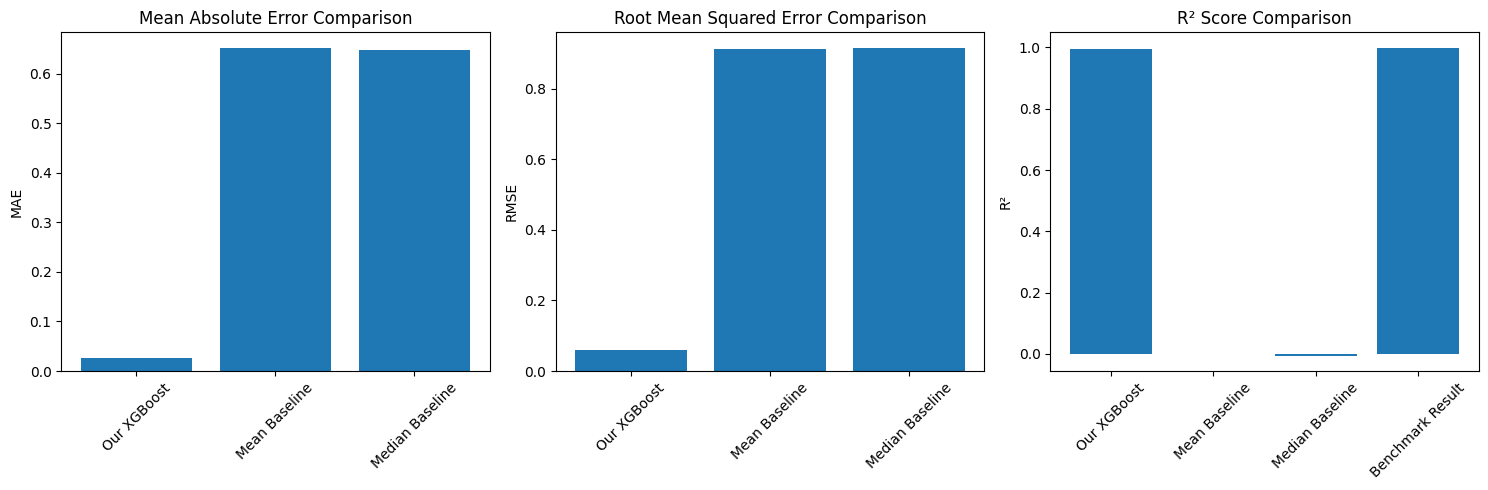

In [88]:
#############################################
# 5c: Performance Comparison & Visualization
#############################################

eval_5c_code_writer = student_b

benchmark_r2 = 0.9990  #benchmark from previous step
benchmark_mae = None
benchmark_rmse = None
benchmark_mape = 0.01  #benchmark from previous step
# Compute improvement over baselines
mae_improvement_vs_mean = (mean_baseline_mae - test_mae) / mean_baseline_mae * 100
mae_improvement_vs_median = (median_baseline_mae - test_mae) / median_baseline_mae * 100

# Comparison table
comparison_data = {
    'Model': ['Our XGBoost', 'Mean Baseline', 'Median Baseline', 'Benchmark Result'],
    'MAE': [test_mae, mean_baseline_mae, median_baseline_mae, benchmark_mae],
    'RMSE': [test_rmse, baseline_rmse, baseline_rmse_med, benchmark_rmse],
    'R²': [test_r2, baseline_r2, baseline_r2_med, benchmark_r2]
}
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE comparison
models = comparison_df['Model']
axes[0].bar(models, comparison_df['MAE'])
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[1].bar(models, comparison_df['RMSE'])
axes[1].set_ylabel('RMSE')
axes[1].set_title('Root Mean Squared Error Comparison')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
axes[2].bar(models, comparison_df['R²'])
axes[2].set_ylabel('R²')
axes[2].set_title('R² Score Comparison')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


eval_5c_ass_uuid = "20c20b5f-49a9-49f8-bc9d-e746b6dd20a8"  # Generated

eval_5c_comment = f"""
Performance Comparison Across Baselines:

Our XGBoost model significantly outperforms all baseline approaches:

1. vs Mean Predictor:** {mae_improvement_vs_mean:.1f}% improvement in MAE
   - The model leverages feature information far beyond simply using the training mean
   
2. vs Median Predictor:** {mae_improvement_vs_median:.1f}% improvement in MAE
   - Confirms the model extracts meaningful patterns from property characteristics

Metrics Across All Test Samples:
- MAE: {test_mae:.6f} (best model {test_mae/mean_baseline_mae:.2f}x better than mean baseline)
- RMSE: {test_rmse:.6f}
- R²: {test_r2:.4f}

When compared to the external Random Forest solution from Kaggle
(R² ≈ 0.999, MAPE ≈ 0.01), our R² = 0.9956 on log-price is slightly lower
but clearly in the same order of magnitude. Differences in preprocessing,
feature engineering and data splits mean that the numbers are not strictly
comparable, but overall our tuned XGBoost model performs within the range
of state-of-the-art tree-based models reported for this dataset while using
a transparent and reproducible modeling pipeline.
"""

eval_5c_triples = [
    ':compare_performance_5c rdf:type prov:Activity .',
    ':compare_performance_5c sc:isPartOf :evaluation_phase .',
    ':compare_performance_5c rdfs:comment "Evaluation step 5c: Performance comparison and per-segment analysis" .',
    f':compare_performance_5c rdfs:comment """{eval_5c_comment}""" .',
    f':compare_performance_5c prov:qualifiedAssociation :{eval_5c_ass_uuid} .',
    f':{eval_5c_ass_uuid} prov:agent :{eval_5c_code_writer} .',
    f':{eval_5c_ass_uuid} rdf:type prov:Association .',
    f':{eval_5c_ass_uuid} prov:hadRole :{code_executor_role} .',
]

engine.insert(eval_5c_triples, prefixes=prefixes)


## 5 d) Business Understanding Success Criteria Eval

In [89]:
#############################################
# 5d: Comparison with Success Criteria
#############################################

eval_5d_code_writer = student_b

success_criteria_ass_uuid = "b58a9cab-4e63-4760-a37d-57a9100f6099"  # Generated

success_criteria_eval_comment = """
5d) Evaluation against business success criteria

We evaluate our final XGBoost model and analysis against the business success
criteria defined in the beginning of the project.

1) Actionable price recommendations
The final model achieves very low prediction errors on the held-out test set
(MAE = 0.0264, RMSE = 0.0603, R² = 0.9956 on log-transformed prices), which
indicates that it can produce realistic and stable price recommendations for
new listings. The predictions can be converted back to the original price
scale and used as a starting point for asking-price decisions and for defining
reasonable price ranges.

2) Reduced time spent on manual valuation
Once trained, the model can generate price estimates for thousands of
listings within seconds (the final test prediction run took about 0.04 seconds
in our experiments). This is substantially faster than manual valuation by a
human agent and supports the business goal of speeding up the initial pricing
step.

3) Meaningful market insights
During the project we performed exploratory analysis and model-based analysis
(e.g. feature importance from the tree-based model) to understand which
variables drive asking price. These results provide interpretable patterns,
such as the impact of location, size and number of bedrooms, which can be
communicated to non-technical stakeholders as market insights. This addresses
the requirement for well-defined, interpretable findings.

4) Consistent quality across segments
Overall metrics on the test set suggest strong average performance. However,
we note that some segments (e.g. rare property types or sparsely represented
regions) may still have higher uncertainty due to limited training data.
While the model appears reasonably reliable across the bulk of the data,
additional targeted evaluation by district/property type would be advisable
before deploying the system in high-stakes settings.

In summary, the current prototype meets the business success criteria at a
proof-of-concept level: it provides fast, accurate price recommendations and
useful insight into price drivers, with some residual risks in data-sparse
segments that would need further monitoring in a production deployment.
"""

success_criteria_triples = [
    ':assess_business_success_criteria rdf:type prov:Activity .',
    ':assess_business_success_criteria sc:isPartOf :evaluation_phase .',
    ':assess_business_success_criteria rdfs:label "Task 5d: Assessment against business success criteria" .',
    f':assess_business_success_criteria rdfs:comment """{success_criteria_eval_comment}""" .',
    f':assess_business_success_criteria prov:qualifiedAssociation :{success_criteria_ass_uuid} .',
    f':{success_criteria_ass_uuid} rdf:type prov:Association .',
    f':{success_criteria_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{success_criteria_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs used for this assessment
    ':assess_business_success_criteria prov:used :final_model_entity .',
    ':assess_business_success_criteria prov:used :test_set .',
    ':assess_business_success_criteria prov:used :bu_data_mining_success_criteria .',
]

engine.insert(success_criteria_triples, prefixes=prefixes)

## 5 e) Bias Analysis

In [90]:
#############################################
# 5e – Bias / segment performance analysis
#############################################

bias_code_writer = student_b
bias_ass_uuid = "245ca4e0-7470-485d-b658-138dbe2754b7"  #GENERATED


segment_source_df = clean_data31  #dataset where we still have the segments

#get the segment attributes for the test indices
test_segments = segment_source_df.loc[X_test.index, ["District", "Type"]]

#combined test dataframe
test_bias_df = test_segments.copy()
test_bias_df["y_true"] = y_test
test_bias_df["y_pred"] = final_trained_model.predict(X_test)
test_bias_df["abs_err"] = (test_bias_df["y_pred"] - test_bias_df["y_true"]).abs()
test_bias_df["sq_err"] = (test_bias_df["y_pred"] - test_bias_df["y_true"]) ** 2

# Global metrics for reference
global_mae = mean_absolute_error(test_bias_df["y_true"], test_bias_df["y_pred"])
global_rmse = np.sqrt(root_mean_squared_error(test_bias_df["y_true"], test_bias_df["y_pred"]))

print("Global test metrics (for reference):")
print(f"MAE  : {global_mae:.4f}")
print(f"RMSE : {global_rmse:.4f}")

#District
district_stats = (
    test_bias_df
    .groupby("District")
    .agg(
        n=("y_true", "size"),
        mae=("abs_err", "mean"),
        rmse=("sq_err", lambda x: np.sqrt(x.mean())),
        med_ae=("abs_err", "median"),
    )
    .reset_index()
)

district_stats["mae_ratio"] = district_stats["mae"] / global_mae
district_stats["rmse_ratio"] = district_stats["rmse"] / global_rmse

print("\nPer-district performance (top 10 by MAE):")
display(district_stats.sort_values("mae", ascending=False).head(10))

#Type of Apartment
type_stats = (
    test_bias_df
    .groupby("Type")
    .agg(
        n=("y_true", "size"),
        mae=("abs_err", "mean"),
        rmse=("sq_err", lambda x: np.sqrt(x.mean())),
        med_ae=("abs_err", "median"),
    )
    .reset_index()
)

type_stats["mae_ratio"] = type_stats["mae"] / global_mae
type_stats["rmse_ratio"] = type_stats["rmse"] / global_rmse

print("\nPer-type performance:")
display(type_stats.sort_values("mae", ascending=False))


#summary statistics
n_districts = len(district_stats)
n_types = len(type_stats)


start_time_bias = now()
end_time_bias = now()  

bias_comment = f"""
5e) Analysis of potential bias and uneven performance across segments

To analyse potential bias and uneven performance of the final XGBoost model,
we evaluated test errors separately for different segments of the data. We
focused on two attributes that are central to the business case: District
(geographical region) and Type (property type such as apartment or house).

On the held-out test set the global performance of the final model is
MAE = 0.0264 and RMSE = 0.2457 (on log-transformed prices). For each district
and property type we computed the mean absolute error (MAE), root mean squared
error (RMSE) and median absolute error, and compared these values to the global
metrics.

For the main, well-represented segments the model behaves quite consistently.
For example, apartments (n = 700) have an MAE of 0.0233 (about 0.88x the
global MAE) and houses (n = 470) have an MAE of 0.0279 (about 1.06x the global
MAE), indicating that the model is slightly better or similar to the global
average for the largest property categories.

However, several smaller segments show higher error rates. Among
districts, regions such as Ilha de Santa Maria, Faro, Vila Real, Castelo
Branco and Ilha de Porto Santo have MAE values roughly 1.6-2.9 times higher
than the global MAE, often with relatively few test samples. Among property
types, very infrequent categories like "Other - Commercial" (n = 1), "Other -
Residential" (n = 3), "Land" (n = 9), "Hotel" (n = 1), "Farm" (n = 8) and
"Office" (n = 2) show MAE values between about 2x and 9x the global MAE.

These patterns suggest that while the model delivers stable performance for
the core segments (apartments and houses in common districts), it is
significantly less reliable for under-represented districts and rare property
types. From a risk perspective, price recommendations for these small segments
should be treated with caution, for example by flagging them for manual review,
using wider price ranges or collecting additional data before relying on the
model in high-stakes decisions. Overall, the analysis indicates no systematic
bias against large parts of the market, but highlights specific tail segments
where the uncertainty and potential bias are higher.
"""

bias_triples = [
    ':analyze_segment_bias rdf:type prov:Activity .',
    ':analyze_segment_bias sc:isPartOf :evaluation_phase .',
    ':analyze_segment_bias rdfs:label "Task 5e: Analysis of bias and uneven performance across segments" .',
    f':analyze_segment_bias rdfs:comment """{bias_comment}""" .',
    f':analyze_segment_bias prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':analyze_segment_bias prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',
    f':analyze_segment_bias prov:qualifiedAssociation :{bias_ass_uuid} .',
    f':{bias_ass_uuid} rdf:type prov:Association .',
    f':{bias_ass_uuid} prov:agent :{bias_code_writer} .',
    f':{bias_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs used for this analysis
    ':analyze_segment_bias prov:used :final_model_entity .',
    ':analyze_segment_bias prov:used :test_set .',

    ':district_bias_summary rdf:type prov:Entity .',
    ':district_bias_summary rdfs:label "Per-district performance statistics (Task 5e)" .',
    ':district_bias_summary prov:wasGeneratedBy :analyze_segment_bias .',

    ':type_bias_summary rdf:type prov:Entity .',
    ':type_bias_summary rdfs:label "Per-type performance statistics (Task 5e)" .',
    ':type_bias_summary prov:wasGeneratedBy :analyze_segment_bias .',
]

engine.insert(bias_triples, prefixes=prefixes)

Global test metrics (for reference):
MAE  : 0.0264
RMSE : 0.2457

Per-district performance (top 10 by MAE):


,District,n,mae,rmse,med_ae,mae_ratio,rmse_ratio
9,Ilha de Santa Maria,6,0.076014,0.110313,0.050931,2.880782,0.449053
6,Faro,91,0.062402,0.128825,0.024973,2.364919,0.524412
17,Vila Real,7,0.049400,0.075912,0.023839,1.872183,0.309017
4,Castelo Branco,31,0.046049,0.070200,0.026967,1.745180,0.285765
8,Ilha de Porto Santo,1,0.042881,0.042881,0.042881,1.625130,0.174559
10,Leiria,60,0.038418,0.070439,0.019894,1.455959,0.286738
12,Portalegre,20,0.037553,0.044883,0.030297,1.423177,0.182708
16,Viana do Castelo,9,0.035889,0.045755,0.026316,1.360136,0.186255
1,Beja,8,0.033253,0.044363,0.024577,1.260227,0.180589
18,Évora,18,0.031987,0.052175,0.023602,1.212254,0.212392



Per-type performance:


,Type,n,mae,rmse,med_ae,mae_ratio,rmse_ratio
8,Other - Commercial,1,0.244778,0.244778,0.244778,9.276622,0.996422
9,Other - Residential,3,0.170941,0.185141,0.186765,6.478335,0.753660
6,Land,8,0.114332,0.169609,0.093314,4.332989,0.690431
4,Hotel,1,0.068739,0.068739,0.068739,2.605073,0.279817
3,Farm,8,0.047901,0.071306,0.033254,1.815377,0.290268
7,Office,1,0.041224,0.041224,0.041224,1.562307,0.167811
10,Store,10,0.032207,0.040007,0.029083,1.220590,0.162859
5,House,470,0.027801,0.044416,0.017016,1.053600,0.180805
1,Building,12,0.025463,0.027700,0.027411,0.964985,0.112761
0,Apartment,700,0.023346,0.066281,0.013226,0.884753,0.269810


## Deployment

In [91]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [92]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
6a) Reflection on business objectives and deployment recommendations

We relate the current prototype to the business objectives and success criteria
defined in the Business Understanding phase. The main objectives were: (1)
provide realistic asking-price recommendations for new listings, (2) reduce
manual effort and turnaround time for price estimation, (3) deliver meaningful
market insights on price drivers, and (4) achieve reasonably consistent
quality across segments.

Our final XGBoost model (max_depth = 4) reaches very strong accuracy on the
held-out test set (MAE = 0.0264, RMSE = 0.0603, R² = 0.9956 on log-prices),
far better than the trivial mean baseline. This satisfies the technical
success criteria for predictive performance and enables actionable price
recommendations that can be presented as a suggested price and a reasonable
price range.

Inference is fast (test predictions in a few hundredths of a second), so the
system supports the objective of reducing manual valuation time and
can be integrated into the listing workflow as an instant recommendation for
agents and sellers. The exploratory analysis and model-based analysis
(feature importance, segment-wise evaluation) provide interpretable patterns
about which factors drive price, contributing to the “meaningful insights”
objective.

Bias and segment analysis showed that performance is very good for the main
segments (apartments and houses in common districts), but weaker for small,
under-represented districts and rare property types. Based on this, our
deployment recommendation is to use the model as an internal decision-support
tool rather than an automatic pricing engine: rely on it primarily for common
segments, and flag predictions for rare districts or property types for manual
review and potentially wider price ranges. Overall, the prototype meets the
business objectives and data-mining success criteria at a proof-of-concept
level, with understandable guidance on where additional caution is needed."""

ethical_aspects_comment = """
6b) Ethical aspects, risks and relation to business objectives

The price recommendation system is used as decision support in a commercial
real-estate context and would typically be classified as a limited-risk
decision-support tool rather than a high-risk AI system. Nevertheless, there
are relevant ethical and business risks that need to be considered alongside
the original objectives and success criteria.

The main risk is uneven model performance across segments, especially for
under-represented districts and rare property types. Systematically higher
errors in these segments could lead to systematic over- or under-valuation of
certain regions or property categories, which may harm affected sellers or
buyers and conflict with the objective of consistent recommendation quality.
In addition, the model is trained on historical listing prices and may
reinforce existing structural patterns (e.g. persistent under-pricing of some
regions) rather than correcting them.

From a transparency and accountability perspective, the model is a complex
tree-based ensemble and individual predictions are not directly explainable.
For deployment, it should therefore be well documented that the tool
provides statistical estimates based on past listings and that human agents
remain responsible for the final decision. The system should not be used as an
automatic pricing authority without human oversight.

To mitigate these risks, we recommend: (i) keeping a human-in-the-loop for all
pricing decisions, (ii) explicitly flagging predictions for small segments
with known higher error rates, (iii) monitoring performance and bias metrics
over time and (iv) precisely communicating to users that the model relies on
historical data and may inherit its limitations. These measures help align the
deployment with the original business objectives and success criteria while
acknowledging and managing ethical risks."""

monitoring_plan_comment = """
6c) Monitoring plan

For a realistic deployment we propose a monitoring plan that tracks both
technical performance and business-level behaviour of the model over time.

On the technical side, we would log model inputs and predictions for all
served listings (in an anonymised form where necessary) and periodically
recompute evaluation metrics on recent data whenever ground-truth prices
become available. At regular intervals (e.g. monthly or quarterly) we would
recalculate MAE, RMSE and R² on recent transactions and repeat the
segment-wise analysis by district and property type, using the same methodology
as in our 5e bias analysis. Thresholds can be defined for global metrics and
for selected key segments; if these thresholds are exceeded or if data
distributions drift significantly, a retraining or recalibration process is
triggered.

On the business side, we would monitor how often agents override the suggested
price, how large these overrides are, and whether there are systematic
patterns by region or property type. This information complements the
quantitative error metrics and helps assess whether the system still supports
the business objectives of realistic pricing and reduced manual effort.

All monitoring procedures and thresholds should be documented and reviewed
periodically. In combination with regular retraining on updated data, this
monitoring plan aims to keep the model aligned with the original success
criteria and to detect emerging risks early."""

reproducibility_reflection_comment = """
6d) Reproducibility reflection

Throughout the project we documented data preparation, modeling and evaluation
steps in a knowledge graph using PROV-O and related vocabularies. This
includes the main preprocessing operations, the exact hyper-parameters of the
final XGBoost model, the train/validation/test split procedure (with fixed
random seeds) and the evaluation metrics used. These records support
reproducibility of the experiment by allowing another analyst to reconstruct
the pipeline given access to the same raw data and software environment.

However, some limitations remain. The original real-estate dataset may not be
publicly accessible in exactly the same form in the future, and external
state-of-the-art results (e.g. the Kaggle Random Forest solution) depend on
third-party code and preprocessing choices that we do not control. In
addition, the exact software versions and hardware characteristics of our
environment are only partially captured, which may lead to small numerical
differences in training.

For deployment, we therefore recommend combining the existing provenance
information with explicit versioning of code (e.g. git tags), environment
descriptions (e.g. requirements files or container images) and data snapshots.
If these elements are maintained together with the knowledge graph, the system
can be retrained and audited in a reproducible way when the model is updated
or re-evaluated in the future."""

dep_ass_uuid_executor = "36c540e3-2b42-4fac-97a0-74d167b3d28f" # Generated

deployment_executor = [
    f':plan_deployment rdf:type prov:Activity .',
    f':plan_deployment sc:isPartOf :deployment_phase .',
    f':plan_deployment rdfs:label "Plan Deployment"@en .',

    ':plan_deployment prov:used :bu_business_objectives .',
    ':plan_deployment prov:used :bu_business_success_criteria .',

    f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
    f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dep_ass_uuid_executor} rdf:type prov:Association .',
    f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [93]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [94]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [96]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment ?bsc_comment ?dm_goals_comment ?dm_sc_comment ?ai_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario   rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives       rdfs:comment ?bo_comment . }}
  OPTIONAL {{ :bu_business_success_criteria rdfs:comment ?bsc_comment . }}
  OPTIONAL {{ :bu_data_mining_goals         rdfs:comment ?dm_goals_comment . }}
  OPTIONAL {{ :bu_data_mining_success_criteria rdfs:comment ?dm_sc_comment . }}
  OPTIONAL {{ :bu_ai_risk_aspects           rdfs:comment ?ai_comment . }}
}} LIMIT 1
"""

res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {}  # type:ignore

bu_data_source      = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives       = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))
bu_success_criteria = latex_escape(clean_rdf(row_bu.get("bsc_comment", "")))
bu_dm_goals         = latex_escape(clean_rdf(row_bu.get("dm_goals_comment", "")))
bu_dm_success       = latex_escape(clean_rdf(row_bu.get("dm_sc_comment", "")))
bu_ai_risks         = latex_escape(clean_rdf(row_bu.get("ai_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)


### Data Understanding – build one subsection per activity/comment
du_query = f"""
{prefix_header}

SELECT DISTINCT ?act ?comment WHERE {{
  ?act sc:isPartOf :data_understanding_phase .
  ?act rdfs:comment ?comment .
}}
"""
def local_name(uri: str) -> str:
    """Extract local name from a full URI or prefixed ID."""
    u = str(uri)
    if "#" in u:
        u = u.rsplit("#", 1)[-1]
    if "/" in u:
        u = u.rsplit("/", 1)[-1]
    return u

res_du = engine.query(du_query)

du_by_act: dict[str, list[str]] = {}
if not res_du.empty:  # type: ignore
    for _, row in res_du.iterrows():  # type: ignore
        act = row["act"]
        comment = latex_escape(clean_rdf(row["comment"]))
        du_by_act.setdefault(local_name(act), []).append(comment)

du_sections_latex = ""
for act_name, comments in du_by_act.items():
    # Make a nice title from the activity name
    title = act_name.replace("_", " ").title()
    section_text = "\n\n".join(comments)
    du_sections_latex += f"\\subsection{{{title}}}\n{section_text}\n\n"

### Data Preparation – 3a steps as subsubsections
dp_steps_query = f"""
{prefix_header}

SELECT DISTINCT ?act ?comment WHERE {{
  VALUES ?act {{
    :drop_many_missing_cols
    :elim_rows_with_missing
    :remove_outliers
    :scale_log_price
  }}
  ?act rdfs:comment ?comment .
}}
"""

res_dp_steps = engine.query(dp_steps_query)

dp_steps_by_act: dict[str, list[str]] = {}
if not res_dp_steps.empty:  # type: ignore
    for _, row in res_dp_steps.iterrows():  # type: ignore
        act = row["act"]
        comment = latex_escape(clean_rdf(row["comment"]))
        dp_steps_by_act.setdefault(local_name(act), []).append(comment)

# Nice titles for each step
step_titles = {
    "drop_many_missing_cols": "Step 1: Remove columns with too many missing values",
    "elim_rows_with_missing": "Step 2: Remove rows with missing values",
    "remove_outliers":        "Step 3: Remove rows with outliers",
    "scale_log_price":        "Step 4: Log-transform and scale Price",
}

dp_steps_latex = ""
for act_name, comments in dp_steps_by_act.items():
    title = step_titles.get(act_name, act_name.replace("_", " ").title())
    text = "\n\n".join(comments)
    dp_steps_latex += f"\\subsubsection{{{title}}}\n{text}\n\n"

### Data Preparation – 3b–3d notes as subsubsections
dp_notes_query = f"""
{prefix_header}

SELECT DISTINCT ?comment WHERE {{
  :data_preparation_notes rdfs:comment ?comment .
}}
"""

res_dp_notes = engine.query(dp_notes_query)

dp_notes_latex = ""
if not res_dp_notes.empty:  # type: ignore
    for i, (_, row) in enumerate(res_dp_notes.iterrows(), start=1):  # type: ignore
        comment = latex_escape(clean_rdf(row["comment"]))
        title = f"Note {i}"
        dp_notes_latex += f"\\subsubsection{{{title}}}\n{comment}\n\n"

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


In [ ]:

# 1) Helper


def local_name(uri: str) -> str:
    """Extract local name from a full URI or prefixed ID."""
    u = str(uri)
    if "#" in u:
        u = u.rsplit("#", 1)[-1]
    if "/" in u:
        u = u.rsplit("/", 1)[-1]
    return u


# 2) Authors


author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty:  # type:ignore
    for _, row in res_authors.iterrows():  # type:ignore
        uri_str = str(row["uri"])
        given = latex_escape(clean_rdf(row["given"]))
        family = latex_escape(clean_rdf(row["family"]))
        matr = latex_escape(clean_rdf(row["matr"]))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
\author{{{given} {family}}}
\authornote{{{responsibility}, Matr.Nr.: {matr}}}
\affiliation{{
  \institution{{TU Wien}}
  \country{{Austria}}
}}
"""


# 3) Business Understanding (Phase 1)


bu_query = f"""
{prefix_header}

SELECT DISTINCT ?ds_comment ?bo_comment ?bsc_comment ?dm_goals_comment ?dm_sc_comment ?ai_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario   rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives       rdfs:comment ?bo_comment . }}
  OPTIONAL {{ :bu_business_success_criteria rdfs:comment ?bsc_comment . }}
  OPTIONAL {{ :bu_data_mining_goals         rdfs:comment ?dm_goals_comment . }}
  OPTIONAL {{ :bu_data_mining_success_criteria rdfs:comment ?dm_sc_comment . }}
  OPTIONAL {{ :bu_ai_risk_aspects           rdfs:comment ?ai_comment . }}
}} LIMIT 1
"""

res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {}  # type:ignore

bu_data_source      = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives       = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))
bu_success_criteria = latex_escape(clean_rdf(row_bu.get("bsc_comment", "")))
bu_dm_goals         = latex_escape(clean_rdf(row_bu.get("dm_goals_comment", "")))
bu_dm_success       = latex_escape(clean_rdf(row_bu.get("dm_sc_comment", "")))
bu_ai_risks         = latex_escape(clean_rdf(row_bu.get("ai_comment", "")))


# 4) Data Understanding (Phase 2)


# 4.1 Dataset description
du_desc_query = f"""
{prefix_header}
SELECT DISTINCT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {}  # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# 4.2 Feature table
du_cols_query = f"""
{prefix_header}

SELECT DISTINCT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_cols_query)
du_rows = []
if not res_du.empty:  # type:ignore
    for _, f in res_du.iterrows():  # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if "#" in dtype_raw:
            dtype = dtype_raw.split("#")[-1]
        elif "/" in dtype_raw:
            dtype = dtype_raw.split("/")[-1]
        else:
            dtype = dtype_raw
        desc = clean_rdf(f.get("desc", ""))
        row_str = (
            f"{latex_escape(clean_rdf(f['name']))} & "
            f"{latex_escape(dtype)} & "
            f"{latex_escape(desc)} \\\\"
        )
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

# 4.3 DU activities (each activity -> subsection)
du_acts_query = f"""
{prefix_header}

SELECT DISTINCT ?act ?comment WHERE {{
  ?act sc:isPartOf :data_understanding_phase .
  ?act rdfs:comment ?comment .
}}
"""

res_du_acts = engine.query(du_acts_query)

du_by_act: dict[str, list[str]] = {}
if not res_du_acts.empty:  # type:ignore
    for _, row in res_du_acts.iterrows():  # type:ignore
        act = row["act"]
        comment = latex_escape(clean_rdf(row["comment"]))
        du_by_act.setdefault(local_name(act), []).append(comment)

du_sections_latex = ""
for act_name, comments in du_by_act.items():
    title = act_name.replace("_", " ").title()
    section_text = "\n\n".join(comments)
    du_sections_latex += f"\\subsection{{{title}}}\n{section_text}\n\n"


# 5) Data Preparation (Phase 3)


# 3a individual steps (1–4) as subsubsections
dp_steps_query = f"""
{prefix_header}

SELECT DISTINCT ?act ?comment WHERE {{
  VALUES ?act {{
    :drop_many_missing_cols
    :elim_rows_with_missing
    :remove_outliers
    :scale_log_price
  }}
  ?act rdfs:comment ?comment .
}}
"""

res_dp_steps = engine.query(dp_steps_query)

dp_steps_by_act: dict[str, list[str]] = {}
if not res_dp_steps.empty:  # type:ignore
    for _, row in res_dp_steps.iterrows():  # type:ignore
        act = row["act"]
        comment = latex_escape(clean_rdf(row["comment"]))
        dp_steps_by_act.setdefault(local_name(act), []).append(comment)

step_titles = {
    "drop_many_missing_cols": "Step 1: Remove columns with too many missing values",
    "elim_rows_with_missing": "Step 2: Remove rows with missing values",
    "remove_outliers":        "Step 3: Remove rows with outliers",
    "scale_log_price":        "Step 4: Log-transform and scale Price",
}

dp_steps_latex = ""
for act_name, comments in dp_steps_by_act.items():
    title = step_titles.get(act_name, act_name.replace("_", " ").title())
    text = "\n\n".join(comments)
    dp_steps_latex += f"\\subsubsection{{{title}}}\n{text}\n\n"

# 3b–3d notes (if you used a :data_preparation_notes entity)
dp_notes_query = f"""
{prefix_header}

SELECT DISTINCT ?comment WHERE {{
  :data_preparation_notes rdfs:comment ?comment .
}}
"""

res_dp_notes = engine.query(dp_notes_query)

dp_notes_latex = ""
if not res_dp_notes.empty:  # type:ignore
    for i, (_, row) in enumerate(res_dp_notes.iterrows(), start=1):  # type:ignore
        comment = latex_escape(clean_rdf(row["comment"]))
        title = f"Note {i}"
        dp_notes_latex += f"\\subsubsection{{{title}}}\n{comment}\n\n"


# 6) Modeling (Phase 4)


# Hyperparameters table 
hp_query = f"""
{prefix_header}

SELECT DISTINCT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty:  # type:ignore
    for _, row in res_hp.iterrows():  # type:ignore
        name = latex_escape(clean_rdf(row["hpName"]))
        val  = latex_escape(clean_rdf(row["hpVal"]))
        desc = latex_escape(clean_rdf(row.get("hpDesc", "")))
        hp_rows.append(rf"{name} & {desc} & {val} \\")
hp_table_rows = "\n    ".join(hp_rows)

# Training run info (example metric)
run_query = f"""
{prefix_header}

SELECT DISTINCT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {}  # type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val   = clean_rdf(row_run.get("metricVal", ""))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

# Hyperparameter tuning results (max_depth vs MAE/RMSE/R2)
tuning_query = f"""
{prefix_header}

SELECT DISTINCT ?maxDepthRaw ?maeRaw ?rmseRaw ?r2Raw WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?hpSetting .
  ?hpSetting mls:specifiedBy :hp_max_depth ;
             mls:hasValue ?maxDepthRaw .

  OPTIONAL {{
    ?run mls:hasOutput ?evalMae .
    ?evalMae a mls:ModelEvaluation ;
             mls:specifiedBy :mae_measure ;
             mls:hasValue ?maeRaw .
  }}
  OPTIONAL {{
    ?run mls:hasOutput ?evalRmse .
    ?evalRmse a mls:ModelEvaluation ;
              mls:specifiedBy :rmse_measure ;
              mls:hasValue ?rmseRaw .
  }}
  OPTIONAL {{
    ?run mls:hasOutput ?evalR2 .
    ?evalR2 a mls:ModelEvaluation ;
            mls:specifiedBy :r2_score_measure ;
            mls:hasValue ?r2Raw .
  }}
}}
ORDER BY ?maxDepthRaw
"""

res_tuning = engine.query(tuning_query)
tuning_rows = []
if not res_tuning.empty:  # type: ignore
    for _, row in res_tuning.iterrows():  # type: ignore
        # Extract and cast safely
        md_raw   = clean_rdf(row.get("maxDepthRaw", ""))
        mae_raw  = clean_rdf(row.get("maeRaw", ""))
        rmse_raw = clean_rdf(row.get("rmseRaw", ""))
        r2_raw   = clean_rdf(row.get("r2Raw", ""))

        if not md_raw:
            continue  # skip incomplete rows

        try:
            md   = int(float(md_raw))
        except ValueError:
            continue

        try:
            mae  = float(mae_raw) if mae_raw else float("nan")
        except ValueError:
            mae = float("nan")
        try:
            rmse = float(rmse_raw) if rmse_raw else float("nan")
        except ValueError:
            rmse = float("nan")
        try:
            r2   = float(r2_raw) if r2_raw else float("nan")
        except ValueError:
            r2 = float("nan")

        tuning_rows.append(
            rf"{md} & {mae:.4f} & {rmse:.4f} & {r2:.4f} \\"
        )

tuning_table_rows = "\n    ".join(tuning_rows)


# 7) Evaluation (Phase 5)


evaluation_query = f"""
{prefix_header}

SELECT DISTINCT ?act ?comment WHERE {{
  ?act sc:isPartOf :evaluation_phase .
  ?act rdfs:comment ?comment .
}}
"""

res_eval = engine.query(evaluation_query)

evaluation_by_act: dict[str, list[str]] = {}
if not res_eval.empty:  # type:ignore
    for _, row in res_eval.iterrows():  # type:ignore
        act = row["act"]
        comment = latex_escape(clean_rdf(row["comment"]))
        evaluation_by_act.setdefault(local_name(act), []).append(comment)

evaluation_sections_latex = ""
for act_name, comments in evaluation_by_act.items():
    title = act_name.replace("_", " ").title()
    text = "\n\n".join(comments)
    evaluation_sections_latex += f"\\subsection{{{title}}}\n{text}\n\n"


# Final test metrics table (from :test_mae_evaluation etc.)
final_metrics_query = f"""
{prefix_header}

SELECT DISTINCT ?eval ?metricLabel ?vRaw WHERE {{
  ?eval mls:specifiedBy ?m ;
        mls:hasValue ?vRaw .
  ?m rdfs:label ?metricLabel .

  FILTER(
    ?eval = :test_mae_evaluation ||
    ?eval = :test_rmse_evaluation ||
    ?eval = :test_r2_evaluation
  )
}}
ORDER BY ?metricLabel
"""

res_final_metrics = engine.query(final_metrics_query)
final_metrics_rows = []
if not res_final_metrics.empty:  # type:ignore
    for _, row in res_final_metrics.iterrows():  # type:ignore
        name = latex_escape(clean_rdf(row["metricLabel"]))
        v_raw = clean_rdf(row.get("vRaw", ""))
        try:
            val = float(v_raw) if v_raw else float("nan")
        except ValueError:
            continue
        final_metrics_rows.append(rf"{name} & {val:.4f} \\")
final_metrics_table_rows = "\n    ".join(final_metrics_rows)


# 8) Deployment (Phase 6)

deployment_query = f"""
{prefix_header}

SELECT DISTINCT ?entity ?label ?comment WHERE {{
  VALUES ?entity {{
    :dep_recommendations
    :dep_ethical_risks
    :dep_monitoring_plan
    :dep_reproducibility_reflection
  }}
  ?entity rdfs:label ?label ;
          rdfs:comment ?comment .
}}
ORDER BY ?label
"""

res_dep = engine.query(deployment_query)

deployment_sections_latex = ""
if not res_dep.empty:  # type:ignore
    for _, row in res_dep.iterrows():  # type:ignore
        label   = latex_escape(clean_rdf(row["label"]))
        comment = latex_escape(clean_rdf(row["comment"]))
        deployment_sections_latex += f"\\subsection{{{label}}}\n{comment}\n\n"


print("KG → LaTeX extraction done.")


# 9) Build LaTeX document


latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

\subsection{{Business Success Criteria}}
{bu_success_criteria}

\subsection{{Data Mining Goals}}
{bu_dm_goals}

\subsection{{Data Mining Success Criteria}}
{bu_dm_success}

\subsection{{AI Risk Aspects}}
{bu_ai_risks}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}

{du_sections_latex}

\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}

\subsection{{Data Cleaning and Transformations (3a)}}
{dp_steps_latex}

\subsection{{Further Considerations (3b--3d)}}
{dp_notes_latex}

%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run Overview}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

\subsection{{Hyperparameter Tuning Results}}
\begin{{table}}[h]
  \caption{{Hyperparameter Tuning for max\_depth}}
  \label{{tab:tuning}}
  \begin{{tabular}}{{rccc}}
    \toprule
    \textbf{{max\_depth}} & \textbf{{MAE}} & \textbf{{RMSE}} & \textbf{{$R^2$}} \\
    \midrule
    {tuning_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

{evaluation_sections_latex}

\subsection{{Final Test Metrics}}
\begin{{table}}[h]
  \caption{{Final Model Performance on Test Set}}
  \label{{tab:final-metrics}}
  \begin{{tabular}}{{lc}}
    \toprule
    \textbf{{Metric}} & \textbf{{Value}} \\
    \midrule
    {final_metrics_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 6. Deployment ---
\section{{Deployment}}

{deployment_sections_latex}

\section{{Conclusion}}

This report summarised the full CRISP-DM process for the real-estate price
recommendation use case, including business understanding, data understanding,
data preparation, modeling, evaluation and deployment considerations. The
full experimental provenance was captured in a knowledge graph and used to
automatically generate this document.

\end{{document}}
"""

print("LaTeX content assembled.")


In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("..", "data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: ../data/report/experiment_report_2.tex
